## Samenvatting notebook

#### In dit notebook heb ik vooral: 
- Csv ingelezen naar pandas dataframe
- Rijen met KWC waarden boven de 0 eruit filteren
- Chlfa waarden visueel geëxploreerd
- Relevante variabelen geselecteerd 
- dataframe gepivot met oog op analyse
- locaties geselecteerd met metingen van relevante variabelen
- functies geschreven voor detecteren en verwijderen outliers
- kaart gemaakt met Chlfa locaties mbv geopandas en matplotlib
- interactieve kaart gemaakt met Chlfa locaties mbv folium

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

import folium
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Settings
%matplotlib inline

In [2]:
# Weergave aanpassen aan eigen voorkeur
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
# Csv-bestand in één keer lezen 
#df = pd.read_csv("C:/Users/ajeez/project_rijkswaterstaat/data_tot.csv", encoding="latin1", index_col=0)

In [4]:
# Poging csv in stukken van 100,000 rijen te lezen om RAM niet te overbelasten, na_values: extreme uibijters chlfa naar NaN
chunksize = 100000
TextFileReader = pd.read_csv('C:/Users/Andries Jan/project_rijkswaterstaat/data_tot.csv', encoding="latin1", index_col=0, 
                             chunksize=chunksize, na_values=[1000, -1000], iterator=True)
df = pd.concat(TextFileReader, ignore_index=True)


In [5]:
# Inspectie dataframe
#df.head()
df.tail()

knmi_STN       DATUM      LOC   TIJD        PAR  BGC    WAARDE  KWC  \
2345290     391.0  2016-12-14  BELFBVN  '1230    metbmrn    <  0.002000    0   
2345291     391.0  2016-12-14  BELFBVN  '1230  metbtazrn  NaN  0.000313    0   
2345292     391.0  2016-12-14  BELFBVN  '1230     metxrn    <  0.002000    0   
2345293     391.0  2016-12-14  BELFBVN  '1230      Mlnrn    <  0.001000    0   
2345294     391.0  2016-12-14  BELFBVN  '1230      monrn    <  0.002000    0   

          EHD DOM    WNS  HDH    ANA  CPM BEM  BEW PLT:REFVLAK  PLT:BMH  SGK  \
2345290  ug/l   E  962.0  NVT  A5320   10   S  NVT      WATSGL     -100  NVT   
2345291  ug/l   E  963.0  NVT  A5320   10   S  NVT      WATSGL     -100  NVT   
2345292  ug/l   E  969.0  NVT  A5320   10   S  NVT      WATSGL     -100  NVT   
2345293  ug/l   E  971.0  NVT  A5320   10   S  NVT      WATSGL     -100  NVT   
2345294  ug/l   E  972.0  NVT  A5320   10   S  NVT      WATSGL     -100  NVT   

         ORG  IVS  BTX                  BTN   GBD LOC:TYPE LOC:COORDSRT  \
2345290  NVT  NVT  NVT  Niet van toepassing  MAAS        P           RD   
2345291  NVT  NVT  NVT  Niet van toepassing  MAAS        P           RD   
2345292  NVT  NVT  NVT  Niet van toepassing  MAAS        P           RD   
2345293  NVT  NVT  NVT  Niet van toepassing  MAAS        P           RD   
2345294  NVT  NVT  NVT  Niet van toepassing  MAAS        P           RD   

            LOC:X     LOC:Y     PLT:X     PLT:Y          OGI           ANI  \
2345290  20562000  37018000  20562000  37018000  RIZAMON_LAN  WDXXWGMLLLSD   
2345291  20562000  37018000  20562000  37018000  RIZAMON_LAN  WDXXWGMLLLSD   
2345292  20562000  37018000  20562000  37018000  RIZAMON_LAN  WDXXWGMLLLSD   
2345293  20562000  37018000  20562000  37018000  RIZAMON_LAN  WDXXWGMLLLSD   
2345294  20562000  37018000  20562000  37018000  RIZAMON_LAN  WDXXWGMLLLSD   

                  BHI           BMI   VAT   SYS TYP  TYD:BEGINDAT  \
2345290  RIZAIMMCLLSD  ONXXANIMIAHM  EMMR  CENT  TN      20160113   
2345291  RIZAIMMCLLSD  ONXXANIMIAHM  EMMR  CENT  TN      20160113   
2345292  RIZAIMMCLLSD  ONXXANIMIAHM  EMMR  CENT  TN      20160113   
2345293  RIZAIMMCLLSD  ONXXANIMIAHM  EMMR  CENT  TN      20160113   
2345294  RIZAIMMCLLSD  ONXXANIMIAHM  EMMR  CENT  TN      20160113   

        TYD:BEGINTYD  TYD:EINDDAT TYD:EINDTYD  STA:BEGINDAT STA:BEGINTYD  \
2345290        '1100     20161214       '1230      20160113        '1100   
2345291        '1100     20161214       '1230      20160113        '1100   
2345292        '1100     20161214       '1230      20160113        '1100   
2345293        '1100     20161214       '1230      20160113        '1100   
2345294        '1100     20161214       '1230      20160113        '1100   

         STA:EINDDAT STA:EINDTYD STA:RKSSTATUS  EXTCODE  \
2345290     20161214       '1230             D      NaN   
2345291     20161214       '1230             D      NaN   
2345292     20161214       '1230             D      NaN   
2345293     20161214       '1230             D      NaN   
2345294     20161214       '1230             D      NaN   

                                               BRON         LOCOMS  \
2345290  D:\watze2016.dia:IDT:*DIF*:A:CENT:20170508  Belfeld boven   
2345291  D:\watze2016.dia:IDT:*DIF*:A:CENT:20170508  Belfeld boven   
2345292  D:\watze2016.dia:IDT:*DIF*:A:CENT:20170508  Belfeld boven   
2345293  D:\watze2016.dia:IDT:*DIF*:A:CENT:20170508  Belfeld boven   
2345294  D:\watze2016.dia:IDT:*DIF*:A:CENT:20170508  Belfeld boven   

             DATUMTIJDWAARDE              PAROMS  EHDOMS  WNSOMS  \
2345290  14-12-2016 12:30:00       methobromuron     NaN     NaN   
2345291  14-12-2016 12:30:00  methabenzthiazuron     NaN     NaN   
2345292  14-12-2016 12:30:00           metoxuron     NaN     NaN   
2345293  14-12-2016 12:30:00         monolinuron     NaN     NaN   
2345294  14-12-2016 12:30:00             monuron     NaN     NaN   

                      HDHOMS  \
2345290  Niet van toepassing   
234529

In [6]:
# Kwaliteitskeurmerk metingen: aleen 0 meenemen
df['KWC'].value_counts()

0     2307118
3       32424
6        4022
50        598
53        572
7         394
56        138
57         21
4           4
2           2
60          1
1           1
Name: KWC, dtype: int64

In [111]:
(df['GBD'].value_counts())

MAAS           228434
NOORDZKNL      137125
IJSSMR         100017
RIJN            97565
VOORDTA         96154
TWENTKNL        94521
HARVT           94113
WESTSDE         87251
NIEUWWTWG       79320
SCHELDE         78283
HOLLSKT         70937
EEMSDLD         65444
VOLKRZMR        65103
MARKMR          54200
BERGSMS         54021
WAAL            53324
OOSTSDE         46752
WADDKT          44962
OUDMS           43937
WADDZWT         43125
IJSSL           43118
KANVGNTNZN      42287
KETMR           40961
ZUIDWLVT        40256
LEKKNL          37950
                ...  
LATKNLNBGNM     34901
HOLLDP          34701
WADDZOT         34362
NIEUWMS         32879
EEMMR           30891
AMSDRKNL        30594
ZWARTWTR        28091
VEERSMR         26916
TERSLG          25237
HOLLSIJSL       23765
LEK             22358
VELWMR          22222
IJMR            16436
BREEVTN         14990
CALKNL          14826
OESTGDN         12758
FRIESFT          5722
DOGGBK           5357
WOLDWD           4372
GERMBT    

In [112]:
(df['GBDOMS'].value_counts())

Maas                                        228434
Noordzeekanaal                              137125
IJsselmeer                                  100017
Rijn / Bovenrijn                             97565
Voordelta  (Kustzone, NCP)                   96154
Twente kanaal                                94521
Haringvliet                                  94113
Westerschelde                                87251
Nieuwe Waterweg                              79320
Schelde (Belgie)                             78283
Hollandse kust  (Kustzone, NCP)              70937
Eems-Dollard                                 65444
Volkerak / Zoommeer                          65103
Markermeer                                   54200
Bergsche Maas                                54021
Waal                                         53324
Oosterschelde                                46752
Waddenkust  (Kustzone, NCP)                  44962
Oude Maas                                    43937
Waddenzee west                 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345295 entries, 0 to 2345294
Columns: 118 entries, knmi_STN to UNH
dtypes: float64(55), int64(12), object(51)
memory usage: 2.1+ GB


In [118]:
df["GBD"].value_counts().to_csv('gbd.csv')

In [9]:
df = df[df['KWC'] == 0]
df.info

<bound method DataFrame.info of          knmi_STN       DATUM       LOC   TIJD          PAR  BGC      WAARDE  \
0             NaN  2006-01-05  WALCRN70  '0813     s_NO3NO2  NaN    0.089000   
1             NaN  2006-01-05  WALCRN70  '0813          NO2  NaN    0.008000   
2             NaN  2006-01-05  WALCRN70  '0813          NH4    <    0.002000   
3             NaN  2006-01-05  WALCRN70  '0813          PO4  NaN    0.026000   
4             NaN  2006-01-05  WALCRN70  '0813         SiO2  NaN    0.123000   
5             NaN  2006-01-05  WALCRN70  '0813          NO3  NaN    0.081000   
7             NaN  2006-01-05  WALCRN70  '0813        CHLFa  NaN    0.980000   
8             NaN  2006-01-05  WALCRN70  '0813         FEOa  NaN    0.040000   
9             NaN  2006-01-05  WALCRN70  '0813          POC  NaN    0.160000   
10            NaN  2006-01-05  WALCRN70  '0813            N  NaN    0.033000   
11            NaN  2006-01-05  WALCRN70  '0813           ZS  NaN    6.300000   
12      

In [10]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2307118 entries, 0 to 2345294
Columns: 118 entries, knmi_STN to UNH
dtypes: float64(55), int64(12), object(51)
memory usage: 8.7 GB


In [11]:
df.head(10)

knmi_STN       DATUM       LOC   TIJD       PAR  BGC  WAARDE  KWC   EHD  \
0        NaN  2006-01-05  WALCRN70  '0813  s_NO3NO2  NaN   0.089    0  mg/l   
1        NaN  2006-01-05  WALCRN70  '0813       NO2  NaN   0.008    0  mg/l   
2        NaN  2006-01-05  WALCRN70  '0813       NH4    <   0.002    0  mg/l   
3        NaN  2006-01-05  WALCRN70  '0813       PO4  NaN   0.026    0  mg/l   
4        NaN  2006-01-05  WALCRN70  '0813      SiO2  NaN   0.123    0  mg/l   
5        NaN  2006-01-05  WALCRN70  '0813       NO3  NaN   0.081    0  mg/l   
7        NaN  2006-01-05  WALCRN70  '0813     CHLFa  NaN   0.980    0  ug/l   
8        NaN  2006-01-05  WALCRN70  '0813      FEOa  NaN   0.040    0  ug/l   
9        NaN  2006-01-05  WALCRN70  '0813       POC  NaN   0.160    0  mg/l   
10       NaN  2006-01-05  WALCRN70  '0813         N  NaN   0.033    0  mg/l   

   DOM     WNS   HDH   ANA  CPM    BEM  BEW PLT:REFVLAK  PLT:BMH  SGK  ORG  \
0    E  1238.0   Nnf  A090   10  SW002  NVT      WATSGL     -100  NVT  NVT   
1    E   492.0   Nnf  A090   10  SW002  NVT      WATSGL     -100  NVT  NVT   
2    E   491.0   Nnf  A090   10  SW002  NVT      WATSGL     -100  NVT  NVT   
3    E   380.0   Pnf  A090   10  SW002  NVT      WATSGL     -100  NVT  NVT   
4    E   560.0  Sinf  A090   10  SW002  NVT      WATSGL     -100  NVT  NVT   
5    E   493.0   Nnf  A090   10  SW002  NVT      WATSGL     -100  NVT  NVT   
7    E   282.0   NVT  A200   10  SW002  NVT      WATSGL     -100  NVT  NVT   
8    E   311.0   NVT  A200   10  SW002  NVT      WATSGL     -100  NVT  NVT   
9    E  1082.0    pg  A067   10  SW002  NVT      WATSGL     -100  NVT  NVT   
10   E   490.0    pg  A067   10  SW002  NVT      WATSGL     -100  NVT  NVT   

    IVS  BTX                  BTN      GBD LOC:TYPE LOC:COORDSRT    LOC:X  \
0   NVT  NVT  Niet van toepassing  BREEVTN        P          E50  2404500   
1   NVT  NVT  Niet van toepassing  BREEVTN        P          E50  2404500   
2   NVT  NVT  Niet van toepassing  BREEVTN        P          E50  2404500   
3   NVT  NVT  Niet van toepassing  BREEVTN        P          E50  2404500   
4   NVT  NVT  Niet van toepassing  BREEVTN        P          E50  2404500   
5   NVT  NVT  Niet van toepassing  BREEVTN        P          E50  2404500   
7   NVT  NVT  Niet van toepassing  BREEVTN        P          E50  2404500   
8   NVT  NVT  Niet van toepassing  BREEVTN        P          E50  2404500   
9   NVT  NVT  Niet van toepassing  BREEVTN        P          E50  2404500   
10  NVT  NVT  Niet van toepassing  BREEVTN        P          E50  2404500   

       LOC:Y    PLT:X     PLT:Y             OGI         ANI           BHI  \
0   51572500  2404500  51572500  RIKZMON_CHEMIE  RIKZITLDHG  WDZOUTCHEMIE   
1   51572500  2404500  51572500  RIKZMON_CHEMIE  RIKZITLDHG  WDZOUTCHEMIE   
2   51572500  2404500  51572500  RIKZMON_CHEMIE  RIKZITLDHG  WDZOUTCHEMIE   
3   51572500  2404500  51572500  RIKZMON_CHEMIE  RIKZITLDHG  WDZOUTCHEMIE   
4   51572500  2404500  51572500  RIKZMON_CHEMIE  RIKZITLDHG  WDZOUTCHEMIE   
5   51572500  2404500  51572500  RIKZMON_CHEMIE  RIKZITLDHG  WDZOUTCHEMIE   
7   51572500  2404500  51572500  RIKZMON_CHEMIE  RIKZITLDHG  WDZOUTCHEMIE   
8   51572500  2404500  51572500  RIKZMON_CHEMIE  RIKZITLDHG  WDZOUTCHEMIE   
9   51572500  2404500  51572500  RIKZMON_CHEMIE  RIKZITLDHG  WDZOUTCHEMIE   
10  51572500  2404500  51572500  RIKZMON_CHEMIE  RIKZITLDHG  WDZOUTCHEMIE   

           BMI   VAT   SYS TYP  TYD:BEGINDAT TYD:BEGINTYD  TYD:EINDDAT  \
0   NZXXMTZRWK  POMP  CENT  TN      20060105        '0813     20061220   
1   NZXXMTZRWK  POMP  CENT  TN      20060105        '0813     20061220   
2   NZXXMTZRWK  POMP  CENT  TN      20060105        '0813     20061220   
3   NZXXMTZRWK  POMP  CENT  TN      20060105        '0813     20061220   
4   NZXXMTZRWK  POMP  CENT  TN      20060105        '0813     20061220   
5   NZXXMTZRWK  POMP  CENT  TN      20060105        '0813     20061220   
7   NZXXMTZRWK  POMP  CENT  TN      20060105        '0813    

## Poging tot feature selection

##### We groeperen straks op maandgemiddelde zonder ekening te houden met locatie: waarden maandgemiddeldes worden dus sterk beïnvloed door de verzameling locaties waar die maand is gemeten

In [12]:
df_fs = df.drop(columns=df.columns[12:])
df_fs.drop(columns=['knmi_STN', 'TIJD', 'BGC', 'KWC', 'EHD', 'DOM', 'WNS', 'LOC'], inplace=True)
df_fs.head()

DATUM       PAR  WAARDE   HDH
0  2006-01-05  s_NO3NO2   0.089   Nnf
1  2006-01-05       NO2   0.008   Nnf
2  2006-01-05       NH4   0.002   Nnf
3  2006-01-05       PO4   0.026   Pnf
4  2006-01-05      SiO2   0.123  Sinf

In [13]:
df_fs = df_fs.pivot_table(index=["DATUM"], columns=['PAR', 'HDH'], values='WAARDE')

df_fs.columns = ['_HDH_'.join(col).strip() for col in df_fs.columns.values]

# Herstellen index
df_fs = df_fs.reset_index()
df_fs.head()

DATUM  %AC_HDH_dg  %C_HDH_dg  %DS_HDH_NVT  %GR_HDH_NVT  %GV_HDH_dg  \
0  2006-01-02         NaN        NaN    27.500000    76.333333         NaN   
1  2006-01-03         NaN        NaN    29.666667    66.800000         NaN   
2  2006-01-04         NaN        NaN    37.500000    81.000000         NaN   
3  2006-01-05         NaN        NaN          NaN          NaN         NaN   
4  2006-01-06         NaN        NaN          NaN          NaN         NaN   

   %KGF10_HDH_dg  %KGF16_HDH_dg  %KGF2_HDH_dg  %KGF20_HDH_dg  %KGF32_HDH_dg  \
0      61.575000      63.600000     42.075000      64.325000            NaN   
1      51.666667      52.466667     37.266667      52.633333            NaN   
2      61.950000      64.900000     44.100000      66.050000            NaN   
3            NaN            NaN           NaN            NaN            NaN   
4            NaN            NaN           NaN            NaN            NaN   

   %KGF4_HDH_dg  %KGF50_HDH_dg  %KGF63_HDH_dg  %KGF8_HDH_dg  %KGFG63_HDH_dg  \
0           NaN         65.825      65.950000           NaN             NaN   
1           NaN         53.800      54.033333           NaN             NaN   
2           NaN         70.000      69.950000           NaN            30.1   
3           NaN            NaN            NaN           NaN             NaN   
4           NaN            NaN            NaN           NaN             NaN   

   %O2_HDH_NVT  %OC_HDH_dg  111TClC2a_HDH_NVT  1122T4ClC2a_HDH_NVT  \
0    89.666667    9.500000               0.01                  NaN   
1    91.366667   14.433333               0.01                  NaN   
2    93.500000    6.000000               0.01                  NaN   
3          NaN         NaN                NaN                  NaN   
4    98.000000         NaN                NaN                  NaN   

   112TClC2a_HDH_NVT  11DClC2a_HDH_NVT  11DClC2e_HDH_NVT  1234T4ClBen_HDH_dg  \
0               0.01              0.01              0.05                 NaN   
1               0.01              0.01              0.05                 NaN   
2               0.01              0.01              0.05                 5.0   
3                NaN               NaN               NaN                 NaN   
4                NaN               NaN               NaN                 NaN   

   1235T4ClBen_HDH_dg  123TC1yBen_HDH_NVT  123TClBen_HDH_NVT  \
0                 NaN                0.01               0.01   
1                 NaN                0.01               0.01   
2                 5.0                0.01               0.01   
3                 NaN                 NaN                NaN   
4                 NaN                 NaN                NaN   

   123TClBen_HDH_dg  123TClC3a_HDH_NVT  1245T4ClBen_HDH_NVT  \
0               NaN               0.01                  NaN   
1               NaN               0.01                  NaN   
2               5.0               0.01                  NaN   
3               NaN                NaN                  NaN   
4               NaN                NaN                  NaN   

   1245T4ClBen_HDH_dg  124TC1yBen_HDH_NVT  124TClBen_HDH_NVT  \
0                 NaN                0.01               0.01   
1                 NaN                0.01               0.01   
2                 8.0                 NaN               0.01   
3                 NaN                 NaN                NaN   
4                 NaN                 NaN                NaN   

   124TClBen_HDH_dg  12DClBen_HDH_NVT  12DClBen_HDH_dg  12DClC2a_HDH_NVT  \
0               NaN              0.01              NaN              0.06   
1               NaN              0.01              NaN              0.01   
2              48.0              0.01             66.0              0.01   
3               NaN               NaN              NaN               NaN   
4               NaN               NaN              NaN               NaN   

   12DClC2e_HDH_NVT  12DClC3a_HDH_NVT  12xyln_HDH_NVT  135TC1yBen_HDH_NVT  \
0   

In [14]:
df_fs['DATUM'] = df_fs['DATUM'].str.slice(0, 7)

df_fs.head()


DATUM  %AC_HDH_dg  %C_HDH_dg  %DS_HDH_NVT  %GR_HDH_NVT  %GV_HDH_dg  \
0  2006-01         NaN        NaN    27.500000    76.333333         NaN   
1  2006-01         NaN        NaN    29.666667    66.800000         NaN   
2  2006-01         NaN        NaN    37.500000    81.000000         NaN   
3  2006-01         NaN        NaN          NaN          NaN         NaN   
4  2006-01         NaN        NaN          NaN          NaN         NaN   

   %KGF10_HDH_dg  %KGF16_HDH_dg  %KGF2_HDH_dg  %KGF20_HDH_dg  %KGF32_HDH_dg  \
0      61.575000      63.600000     42.075000      64.325000            NaN   
1      51.666667      52.466667     37.266667      52.633333            NaN   
2      61.950000      64.900000     44.100000      66.050000            NaN   
3            NaN            NaN           NaN            NaN            NaN   
4            NaN            NaN           NaN            NaN            NaN   

   %KGF4_HDH_dg  %KGF50_HDH_dg  %KGF63_HDH_dg  %KGF8_HDH_dg  %KGFG63_HDH_dg  \
0           NaN         65.825      65.950000           NaN             NaN   
1           NaN         53.800      54.033333           NaN             NaN   
2           NaN         70.000      69.950000           NaN            30.1   
3           NaN            NaN            NaN           NaN             NaN   
4           NaN            NaN            NaN           NaN             NaN   

   %O2_HDH_NVT  %OC_HDH_dg  111TClC2a_HDH_NVT  1122T4ClC2a_HDH_NVT  \
0    89.666667    9.500000               0.01                  NaN   
1    91.366667   14.433333               0.01                  NaN   
2    93.500000    6.000000               0.01                  NaN   
3          NaN         NaN                NaN                  NaN   
4    98.000000         NaN                NaN                  NaN   

   112TClC2a_HDH_NVT  11DClC2a_HDH_NVT  11DClC2e_HDH_NVT  1234T4ClBen_HDH_dg  \
0               0.01              0.01              0.05                 NaN   
1               0.01              0.01              0.05                 NaN   
2               0.01              0.01              0.05                 5.0   
3                NaN               NaN               NaN                 NaN   
4                NaN               NaN               NaN                 NaN   

   1235T4ClBen_HDH_dg  123TC1yBen_HDH_NVT  123TClBen_HDH_NVT  \
0                 NaN                0.01               0.01   
1                 NaN                0.01               0.01   
2                 5.0                0.01               0.01   
3                 NaN                 NaN                NaN   
4                 NaN                 NaN                NaN   

   123TClBen_HDH_dg  123TClC3a_HDH_NVT  1245T4ClBen_HDH_NVT  \
0               NaN               0.01                  NaN   
1               NaN               0.01                  NaN   
2               5.0               0.01                  NaN   
3               NaN                NaN                  NaN   
4               NaN                NaN                  NaN   

   1245T4ClBen_HDH_dg  124TC1yBen_HDH_NVT  124TClBen_HDH_NVT  \
0                 NaN                0.01               0.01   
1                 NaN                0.01               0.01   
2                 8.0                 NaN               0.01   
3                 NaN                 NaN                NaN   
4                 NaN                 NaN                NaN   

   124TClBen_HDH_dg  12DClBen_HDH_NVT  12DClBen_HDH_dg  12DClC2a_HDH_NVT  \
0               NaN              0.01              NaN              0.06   
1               NaN              0.01              NaN              0.01   
2              48.0              0.01             66.0              0.01   
3               NaN               NaN              NaN               NaN   
4               NaN               NaN              NaN               NaN   

   12DClC2e_HDH_NVT  12DClC3a_HDH_NVT  12xyln_HDH_NVT  135TC1yBen_HDH_NVT  \
0               NaN

#### Groepeer de rijen tot maandgemiddelde

In [15]:
df_fsg = df_fs.groupby(['DATUM']).mean()
print(df_fsg.shape)
df_fsg.head()

(132, 714)


%AC_HDH_dg  %C_HDH_dg  %DS_HDH_NVT  %GR_HDH_NVT  %GV_HDH_dg  \
DATUM                                                                  
2006-01         NaN        NaN    33.161111    77.727211   14.600000   
2006-02         NaN        NaN    37.202381    78.026515   14.864286   
2006-03         NaN        NaN    37.295238    77.382540   14.966667   
2006-04         NaN        NaN    38.826389    78.565018   14.900000   
2006-05         NaN        NaN    34.166667    76.004082   17.425000   

         %KGF10_HDH_dg  %KGF16_HDH_dg  %KGF2_HDH_dg  %KGF20_HDH_dg  \
DATUM                                                                
2006-01      58.187222      60.827222     40.458333      62.250000   
2006-02      56.861905      57.318627     37.561765      61.140278   
2006-03      53.758095      56.550476     38.322619      57.364881   
2006-04      52.169444      55.372222     36.566667      56.004545   
2006-05      51.004375      53.153137     35.430196      55.331875   

         %KGF32_HDH_dg  %KGF4_HDH_dg  %KGF50_HDH_dg  %KGF63_HDH_dg  \
DATUM                                                                
2006-01            NaN           NaN      64.792222      65.031667   
2006-02      57.357143     39.357143      64.833333      63.719608   
2006-03            NaN           NaN      61.187381      61.398333   
2006-04            NaN           NaN      60.729167      61.156944   
2006-05      53.166667     38.166667      58.828750      58.665098   

         %KGF8_HDH_dg  %KGFG63_HDH_dg  %O2_HDH_NVT  %OC_HDH_dg  \
DATUM                                                            
2006-01           NaN       29.050000    92.910312    8.282778   
2006-02     45.428571       15.459091    95.054540    6.181373   
2006-03           NaN       30.133333    95.178125    9.179524   
2006-04           NaN       33.400000    94.941373    8.771528   
2006-05     44.333333       23.985714   101.187186    9.248148   

         111TClC2a_HDH_NVT  1122T4ClC2a_HDH_NVT  112TClC2a_HDH_NVT  \
DATUM                                                                
2006-01           0.010000                  NaN           0.013542   
2006-02           0.010000                  0.5           0.011212   
2006-03           0.010385                  0.5           0.010769   
2006-04           0.010000                  0.5           0.011818   
2006-05           0.010000                  0.5           0.011389   

         11DClC2a_HDH_NVT  11DClC2e_HDH_NVT  1234T4ClBen_HDH_dg  \
DATUM                                                             
2006-01              0.01              0.05                 5.0   
2006-02              0.01              0.05                 5.0   
2006-03              0.01              0.05                 5.0   
2006-04              0.01              0.05                 5.0   
2006-05              0.01              0.05                 5.0   

         1235T4ClBen_HDH_dg  123TC1yBen_HDH_NVT  123TClBen_HDH_NVT  \
DATUM                                                                
2006-01                 5.0                0.01               0.01   
2006-02                 5.0                0.01               0.01   
2006-03                 5.0                0.01               0.01   
2006-04                 5.0                0.01               0.01   
2006-05                 5.0                0.01               0.01   

         123TClBen_HDH_dg  123TClC3a_HDH_NVT  1245T4ClBen_HDH_NVT  \
DATUM                                                               
2006-01               5.0               0.01                 0.01   
2006-02               5.0               0.01                 0.01   
2006-03               5.0               0.01                 0.01   
2006-04               5.0               0.01                 0.01   
2006-05               5.0               0.01                 0.01   

         1245T4ClBen_HDH_dg  124TC1yBen_HDH_NVT  124TClBen_HDH_NVT  \
DATUM                                                

In [16]:
df_fsg.isnull().sum() / df_fsg.shape[0] * 100

%AC_HDH_dg             96.212121
%C_HDH_dg              96.212121
%DS_HDH_NVT             0.000000
%GR_HDH_NVT             0.000000
%GV_HDH_dg             39.393939
%KGF10_HDH_dg           0.000000
%KGF16_HDH_dg           0.000000
%KGF2_HDH_dg            0.000000
%KGF20_HDH_dg           0.000000
%KGF32_HDH_dg          56.060606
%KGF4_HDH_dg           56.060606
%KGF50_HDH_dg           0.000000
%KGF63_HDH_dg           0.000000
%KGF8_HDH_dg           56.060606
%KGFG63_HDH_dg         15.151515
%O2_HDH_NVT             0.000000
%OC_HDH_dg              0.000000
111TClC2a_HDH_NVT       0.000000
1122T4ClC2a_HDH_NVT     0.757576
112TClC2a_HDH_NVT       0.000000
11DClC2a_HDH_NVT        0.000000
11DClC2e_HDH_NVT        0.000000
1234T4ClBen_HDH_dg      0.000000
1235T4ClBen_HDH_dg      0.000000
123TC1yBen_HDH_NVT      0.000000
                         ...    
s_HCH_HDH_NVT          99.242424
s_MBAS_HDH_NVT          9.090909
s_NO3NO2_HDH_Nnf        0.000000
s_PAK10_HDH_NVT        91.666667
s_PAK16_HD

In [17]:
df_fsg['CHLFa_HDH_NVT'].head()

DATUM
2006-01     3.743691
2006-02     7.706515
2006-03    10.193841
2006-04    16.871878
2006-05    15.199197
Name: CHLFa_HDH_NVT, dtype: float64

In [18]:
half_count = len(df_fsg) / 2
half_count

66.0

In [19]:
df_fsg.dropna(thresh=half_count, axis=1, inplace=True)
df_fsg.shape

(132, 531)

#### Pas methode interpolate op df toe: vervangt NaN door gemiddelde voorafgaande en erop volgende waarde
https://stackoverflow.com/questions/25234782/replace-nan-or-missing-values-with-rolling-mean-or-other-interpolation

In [20]:
df_interpol = df_fsg.interpolate()

In [21]:
df_interpol.isnull().sum() / df_interpol.shape[0] * 100

%DS_HDH_NVT             0.000000
%GR_HDH_NVT             0.000000
%GV_HDH_dg              0.000000
%KGF10_HDH_dg           0.000000
%KGF16_HDH_dg           0.000000
%KGF2_HDH_dg            0.000000
%KGF20_HDH_dg           0.000000
%KGF50_HDH_dg           0.000000
%KGF63_HDH_dg           0.000000
%KGFG63_HDH_dg          0.000000
%O2_HDH_NVT             0.000000
%OC_HDH_dg              0.000000
111TClC2a_HDH_NVT       0.000000
1122T4ClC2a_HDH_NVT     0.757576
112TClC2a_HDH_NVT       0.000000
11DClC2a_HDH_NVT        0.000000
11DClC2e_HDH_NVT        0.000000
1234T4ClBen_HDH_dg      0.000000
1235T4ClBen_HDH_dg      0.000000
123TC1yBen_HDH_NVT      0.000000
123TClBen_HDH_NVT       0.000000
123TClBen_HDH_dg        0.000000
123TClC3a_HDH_NVT       0.000000
1245T4ClBen_HDH_dg      0.000000
124TC1yBen_HDH_NVT      0.000000
                         ...    
propcnzl_HDH_NVT        0.000000
propxr_HDH_NVT          0.000000
propzne_HDH_NVT         0.000000
ptonC1y_HDH_NVT         0.000000
pyrazfs_HD

In [22]:
df_interpol.dropna(axis=1, inplace=True)
df_interpol.shape

(132, 455)

#### Deel dataframe in tweeen

In [23]:
df_interpol1 = df_interpol.iloc[0:61]
df_interpol2 = df_interpol.iloc[61:132]

##### Na één keer het maandgemiddelde genomen te hebben en één keer geïnterpoleerd te hebben blijven er van de 715 nog 455 variabelen zonder NaN's over

#### Gebruik xgboost om voorspellende features te selecteren

In [24]:
X = df_fsg.drop(columns=["CHLFa_HDH_NVT"])
y = df_fsg["CHLFa_HDH_NVT"]

In [25]:
# Train het model op dataset en plot belangrijkste features 
dmatrix = xgb.DMatrix(data=X, label=y)

params = {"objective":"reg:linear", "max_depth":4}

xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

<function matplotlib.pyplot.show>

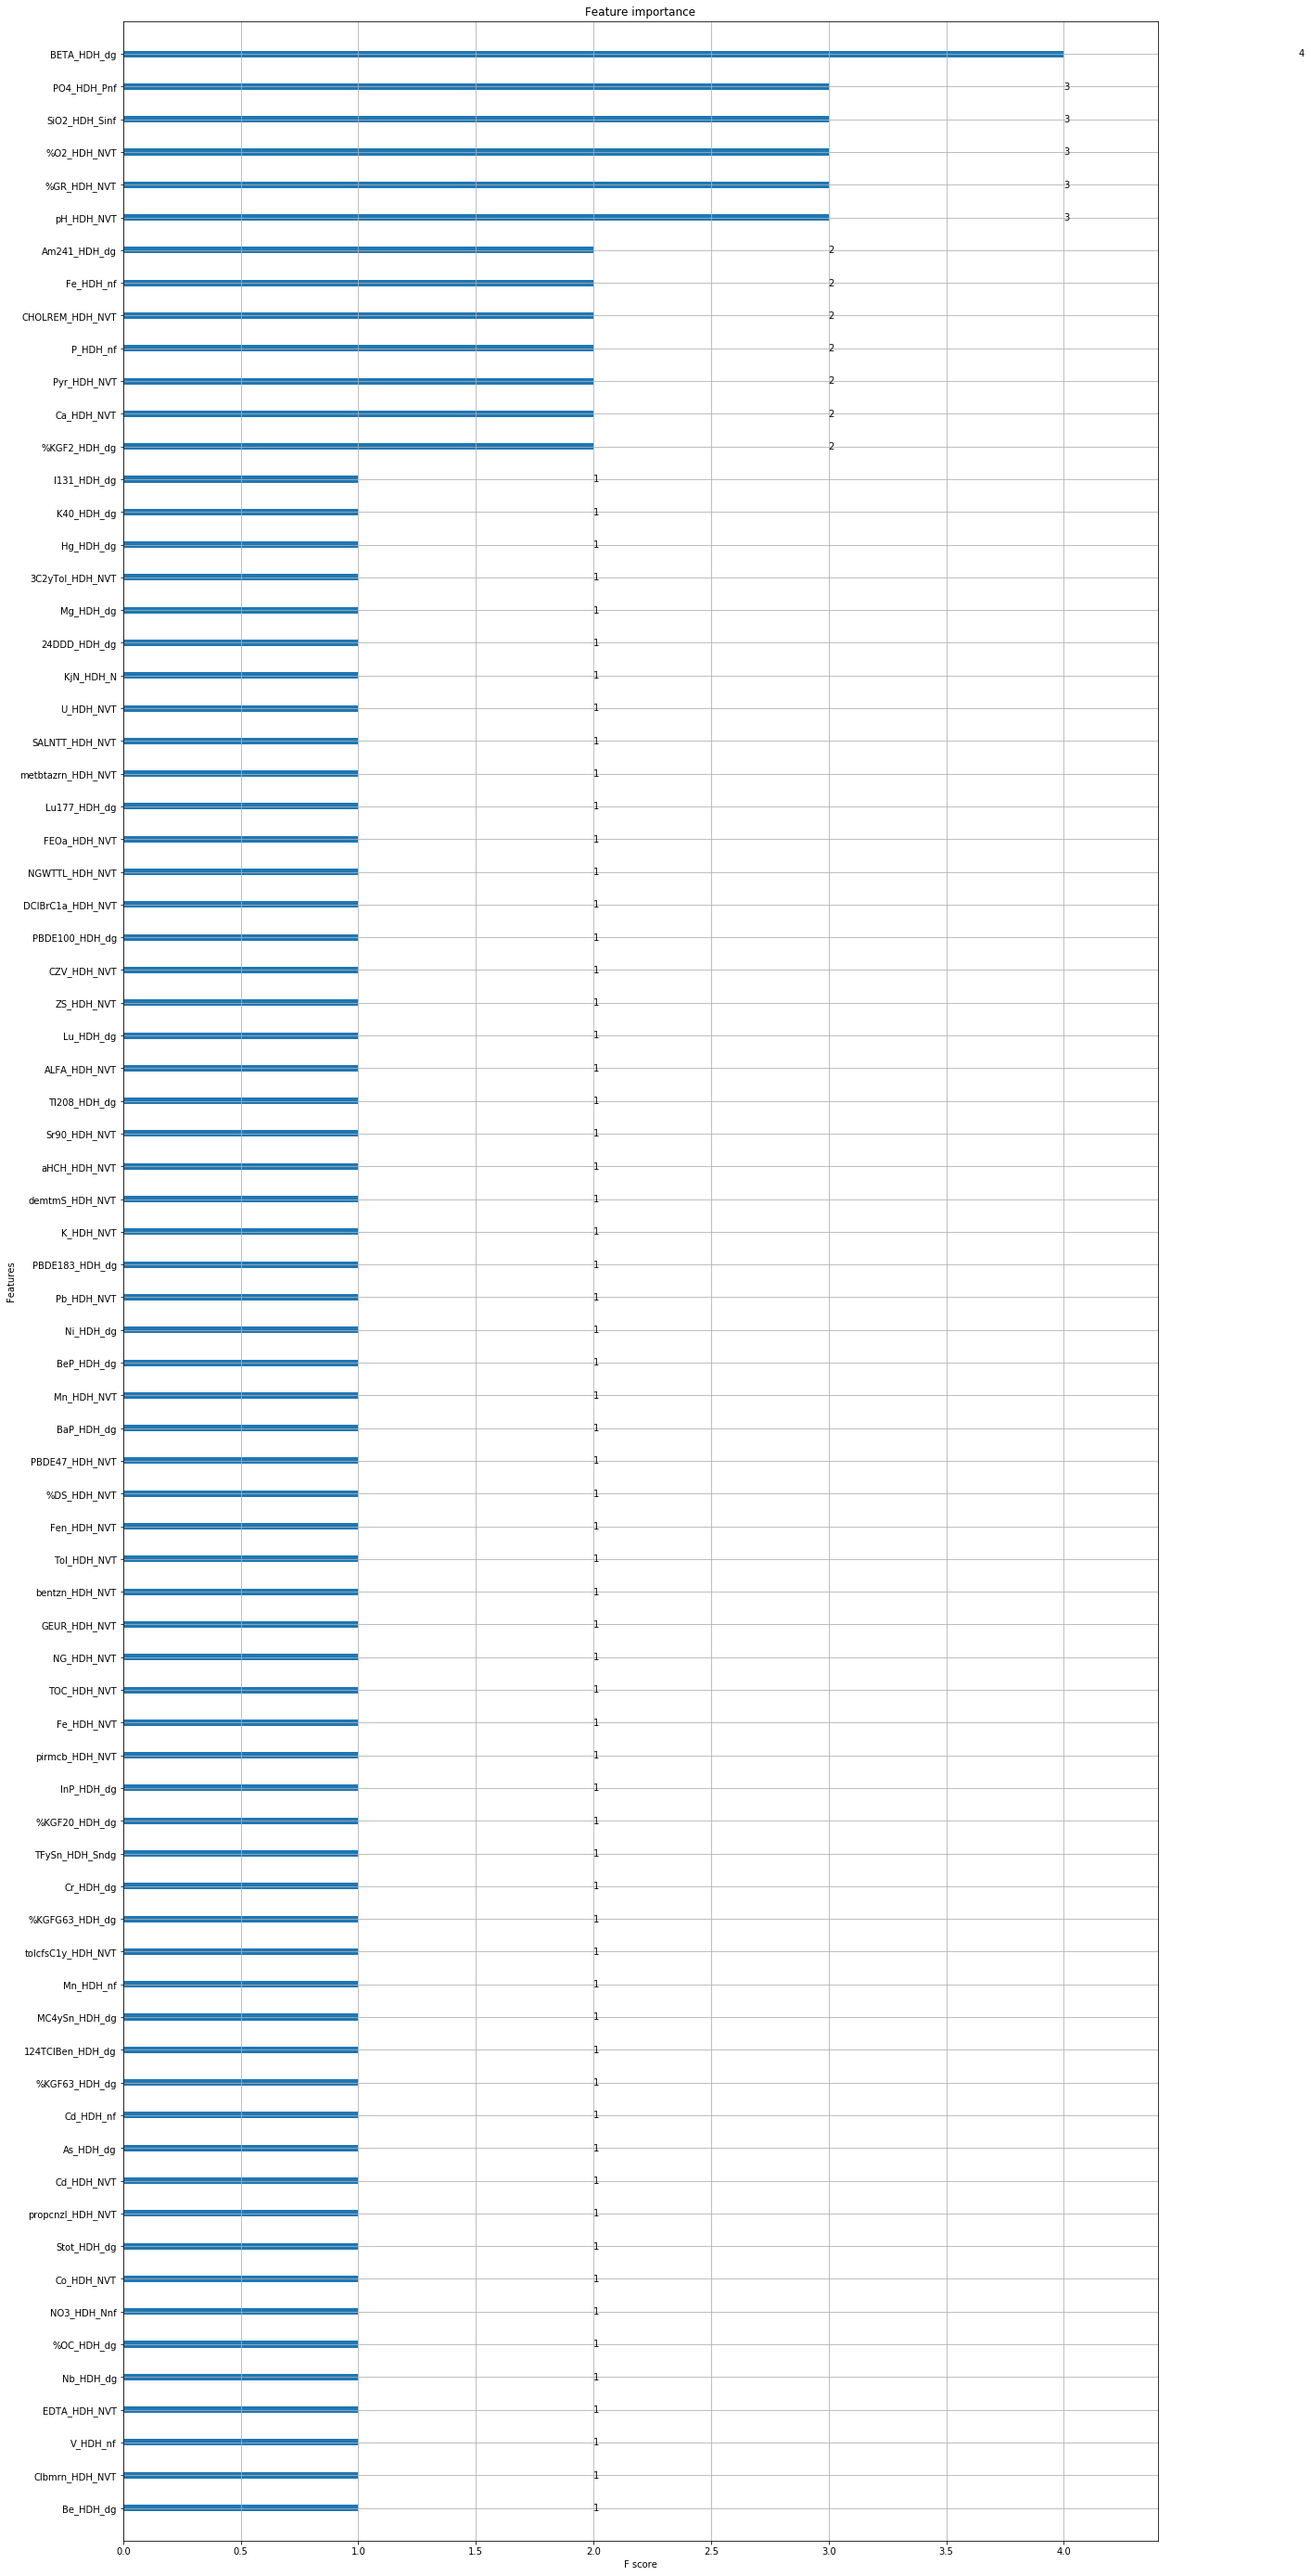

In [26]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(20,50))
xgb.plot_importance(xg_reg, ax=ax)

fig.savefig('feat_sel_chlfa.png')
plt.show

#### Doe het bovenstaande voor df_interpol

In [27]:
X_int = df_interpol.drop(columns=["CHLFa_HDH_NVT"])
y_int = df_interpol[["CHLFa_HDH_NVT"]]

In [28]:
dmatrix_int = xgb.DMatrix(data=X_int, label=y_int)

params = {"objective":"reg:linear", "max_depth":4}

xg_regint = xgb.train(params=params, dtrain=dmatrix_int, num_boost_round=10)

<function matplotlib.pyplot.show>

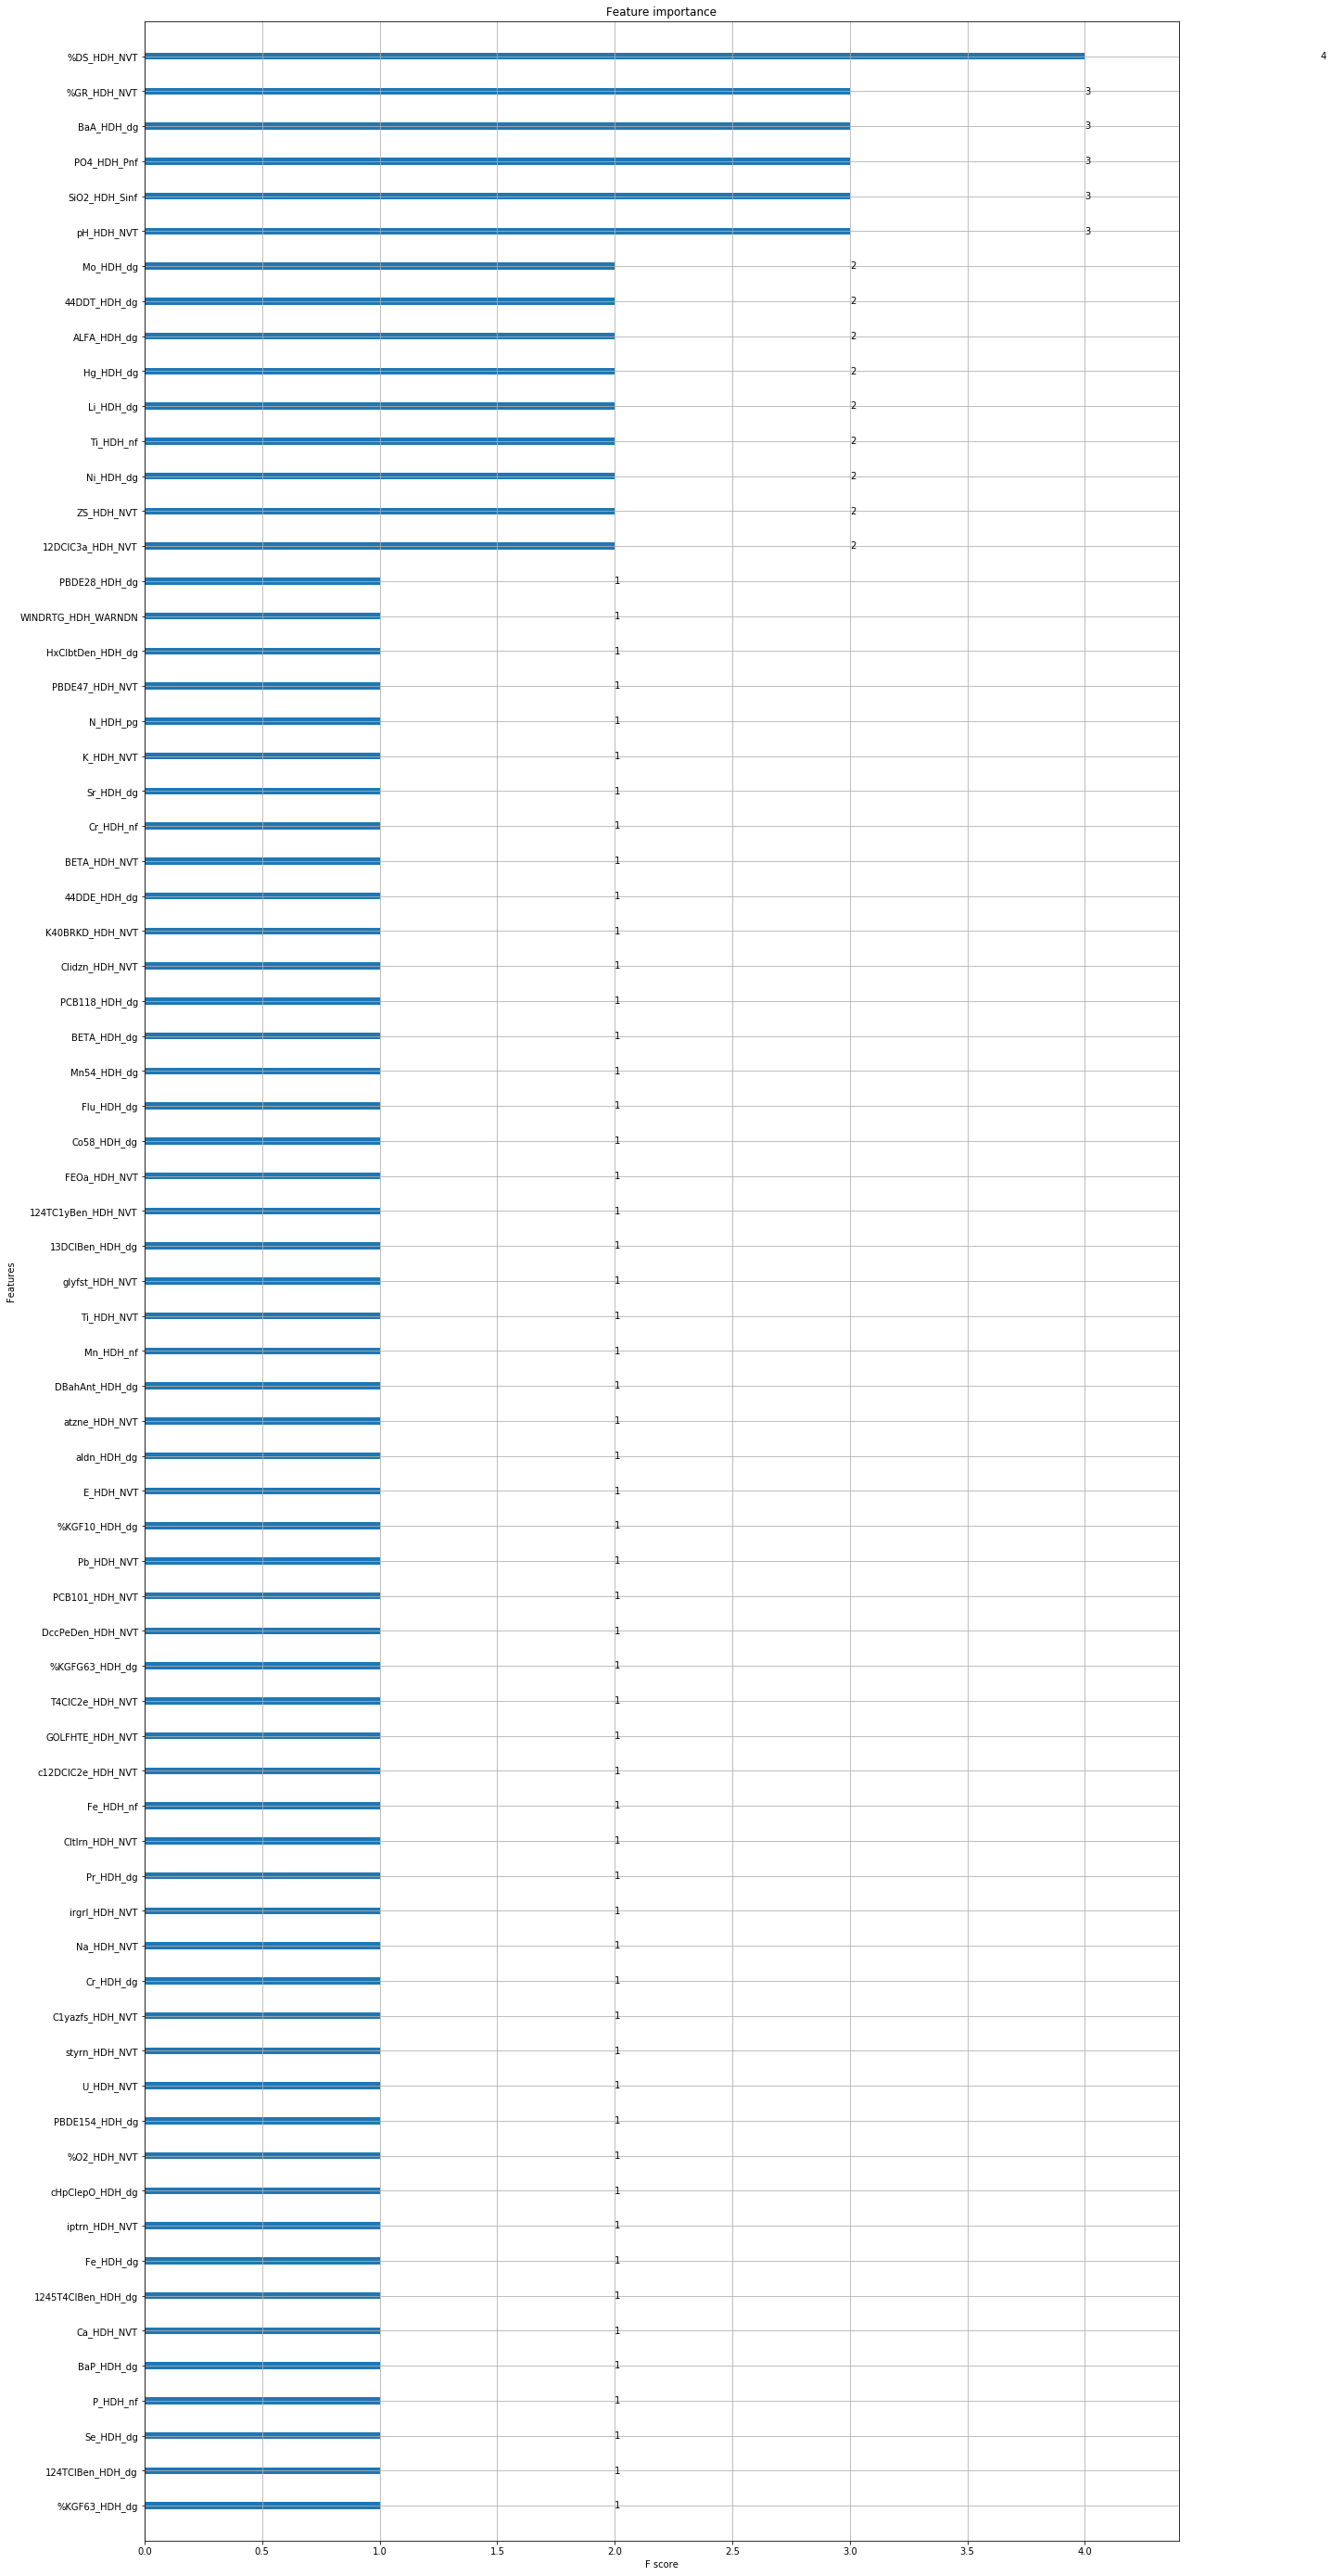

In [29]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(20,50))
xgb.plot_importance(xg_regint, ax=ax)

fig.savefig('feat_int.png')
plt.show

### Feature selection met SelectKBest van sklearn

In [30]:
import sklearn.feature_selection

In [31]:
df_fsg.dropna(axis=1, inplace=True)
df_fsg.head()

%DS_HDH_NVT  %GR_HDH_NVT  %KGF10_HDH_dg  %KGF16_HDH_dg  %KGF2_HDH_dg  \
DATUM                                                                           
2006-01    33.161111    77.727211      58.187222      60.827222     40.458333   
2006-02    37.202381    78.026515      56.861905      57.318627     37.561765   
2006-03    37.295238    77.382540      53.758095      56.550476     38.322619   
2006-04    38.826389    78.565018      52.169444      55.372222     36.566667   
2006-05    34.166667    76.004082      51.004375      53.153137     35.430196   

         %KGF20_HDH_dg  %KGF50_HDH_dg  %KGF63_HDH_dg  %O2_HDH_NVT  %OC_HDH_dg  \
DATUM                                                                           
2006-01      62.250000      64.792222      65.031667    92.910312    8.282778   
2006-02      61.140278      64.833333      63.719608    95.054540    6.181373   
2006-03      57.364881      61.187381      61.398333    95.178125    9.179524   
2006-04      56.004545      60.729167      61.156944    94.941373    8.771528   
2006-05      55.331875      58.828750      58.665098   101.187186    9.248148   

         111TClC2a_HDH_NVT  112TClC2a_HDH_NVT  11DClC2a_HDH_NVT  \
DATUM                                                             
2006-01           0.010000           0.013542              0.01   
2006-02           0.010000           0.011212              0.01   
2006-03           0.010385           0.010769              0.01   
2006-04           0.010000           0.011818              0.01   
2006-05           0.010000           0.011389              0.01   

         11DClC2e_HDH_NVT  1234T4ClBen_HDH_dg  1235T4ClBen_HDH_dg  \
DATUM                                                               
2006-01              0.05                 5.0                 5.0   
2006-02              0.05                 5.0                 5.0   
2006-03              0.05                 5.0                 5.0   
2006-04              0.05                 5.0                 5.0   
2006-05              0.05                 5.0                 5.0   

         123TC1yBen_HDH_NVT  123TClBen_HDH_NVT  123TClBen_HDH_dg  \
DATUM                                                              
2006-01                0.01               0.01               5.0   
2006-02                0.01               0.01               5.0   
2006-03                0.01               0.01               5.0   
2006-04                0.01               0.01               5.0   
2006-05                0.01               0.01               5.0   

         123TClC3a_HDH_NVT  1245T4ClBen_HDH_dg  124TC1yBen_HDH_NVT  \
DATUM                                                                
2006-01               0.01                6.25            0.010556   
2006-02               0.01                6.20            0.010000   
2006-03               0.01                5.00            0.010000   
2006-04               0.01                5.00            0.010152   
2006-05               0.01                5.00            0.010000   

         124TClBen_HDH_NVT  124TClBen_HDH_dg  12DClBen_HDH_NVT  \
DATUM                                                            
2006-01           0.010208            37.625              0.01   
2006-02           0.010152            30.400              0.01   
2006-03           0.010154            13.400              0.01   
2006-04           0.010455            14.600              0.01   
2006-05           0.010000            14.000              0.01   

         12DClBen_HDH_dg  12DClC2a_HDH_NVT  12DClC3a_HDH_NVT  12xyln_HDH_NVT  \
DATUM                                                                          
2006-01        56.000000          0.033750          0.010000        0.015417   
2006-02        46.200000          0.053030          0.010152        0.010909   
2006-03        19.200000          0.035538          0.010000        0.010000   
2006-04        19.600000          0.043030          0.010000        0.010000   
2006-05 

In [32]:
X1 = df_fsg.drop(columns=["CHLFa_HDH_NVT"])
y1 = df_fsg[["CHLFa_HDH_NVT"]]

In [33]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X1, y1, test_size=.2, random_state=123)

In [34]:
print(Xs_train.shape)
print(type(ys_train))

(105, 391)
<class 'pandas.core.frame.DataFrame'>


In [35]:
Xs_train.isnull().sum() / Xs_train.shape[0] * 100

%DS_HDH_NVT           0.0
%GR_HDH_NVT           0.0
%KGF10_HDH_dg         0.0
%KGF16_HDH_dg         0.0
%KGF2_HDH_dg          0.0
%KGF20_HDH_dg         0.0
%KGF50_HDH_dg         0.0
%KGF63_HDH_dg         0.0
%O2_HDH_NVT           0.0
%OC_HDH_dg            0.0
111TClC2a_HDH_NVT     0.0
112TClC2a_HDH_NVT     0.0
11DClC2a_HDH_NVT      0.0
11DClC2e_HDH_NVT      0.0
1234T4ClBen_HDH_dg    0.0
1235T4ClBen_HDH_dg    0.0
123TC1yBen_HDH_NVT    0.0
123TClBen_HDH_NVT     0.0
123TClBen_HDH_dg      0.0
123TClC3a_HDH_NVT     0.0
1245T4ClBen_HDH_dg    0.0
124TC1yBen_HDH_NVT    0.0
124TClBen_HDH_NVT     0.0
124TClBen_HDH_dg      0.0
12DClBen_HDH_NVT      0.0
                     ... 
metbtazrn_HDH_NVT     0.0
metlCl_HDH_NVT        0.0
metxrn_HDH_NVT        0.0
metzCl_HDH_NVT        0.0
mevfs_HDH_NVT         0.0
monrn_HDH_NVT         0.0
pH_HDH_NVT            0.0
pirmcb_HDH_NVT        0.0
propzne_HDH_NVT       0.0
ptonC1y_HDH_NVT       0.0
pyrazfs_HDH_NVT       0.0
s_1214CNB_HDH_dg      0.0
s_1314Xyl_HD

In [36]:


select = sklearn.feature_selection.SelectKBest(k=20)


In [37]:
selected_features = select.fit(Xs_train, ys_train.values.ravel())
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [Xs_train.columns[i] for i in indices_selected]

X_train_selected = Xs_train[colnames_selected]
X_test_selected = Xs_test[colnames_selected]

C:\Users\Andries Jan\anacond\lib\site-packages\sklearn\feature_selection\univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)


In [38]:
X_train_selected

monrn_HDH_NVT  pH_HDH_NVT  pirmcb_HDH_NVT  propzne_HDH_NVT  \
DATUM                                                                 
2015-03       0.011333    8.210417        0.001799         0.000803   
2008-08       0.013462    8.006984        0.004504         0.010000   
2009-07       0.016429    7.990070        0.006610         0.010000   
2007-08       0.013214    8.006244        0.006254         0.010000   
2008-12       0.013000    7.963532        0.005816         0.010000   
2014-10       0.010625    8.053189        0.007863         0.010000   
2007-12       0.015000    7.922094        0.007105         0.010000   
2006-10       0.010000    7.981694        0.006803         0.010000   
2016-01       0.002000    8.004259        0.001149         0.002615   
2015-09       0.010625    8.056352        0.000740         0.000700   
2011-01       0.010000    7.844702        0.007652         0.010000   
2012-01       0.010000    7.908668        0.006778         0.010000   
2009-10       0.016923    7.943952        0.007579         0.010000   
2012-10       0.010000    8.048932        0.007313         0.010000   
2014-04       0.010625    8.180551        0.007280         0.010000   
2013-12       0.010000    7.985461        0.007424         0.010000   
2007-10       0.019000    7.937947        0.007250         0.010000   
2006-12       0.010000    8.011250        0.007299         0.010000   
2015-07       0.010714    8.124823        0.000863         0.000700   
2013-07       0.010000    8.140766        0.007812         0.010000   
2016-12       0.002000    7.967155        0.001163         0.002565   
2012-03       0.010000    8.087900        0.007662         0.010000   
2013-11       0.010000    7.950992        0.007438         0.010000   
2009-06       0.017788    8.096659        0.006589         0.010000   
2009-09       0.015625    7.935420        0.006288         0.010000   
...                ...         ...             ...              ...   
2015-11       0.010333    8.000612        0.001266         0.003626   
2009-01       0.017500    7.997760        0.005636         0.010000   
2012-07       0.010000    8.039917        0.006943         0.010000   
2016-06       0.002000    8.090278        0.001362         0.002381   
2008-02       0.017500    8.007228        0.007541         0.010000   
2015-04       0.010119    8.242372        0.000633         0.001696   
2015-12       0.010667    7.938992        0.000717         0.000700   
2009-11       0.012813    7.932782        0.006432         0.010000   
2008-09       0.016429    7.996311        0.006153         0.010000   
2012-02       0.010000    7.890370        0.005524         0.010000   
2009-12       0.016923    7.919486        0.006280         0.010000   
2015-06       0.010588    8.178873        0.001016         0.000809   
2014-01       0.010333    8.018054        0.007134         0.010000   
2014-02       0.010333    8.035032        0.007674         0.010000   
2013-03       0.010000    8.110383        0.008022         0.010000   
2010-10       0.010000    7.983079        0.008071         0.010000   
2016-04       0.002000    8.216964        0.000826         0.002333   
2014-11       0.010156    8.061340        0.007331         0.010000   
2012-12       0.010000    8.000869        0.007300         0.010000   
2007-06       0.013750    8.081655        0.006038         0.010000   
2014-07       0.010556    8.043805        0.007219         0.010000   
2014-03       0.011333    8.185319        0.008317         0.010000   
2011-07       0.010000    8.169729        0.006070         0.010000   
2016-07       0.002000    8.055483        0.001519         0.002490   
2015-02       0.010313    8.069905        0.001088         0.003219   

         ptonC1y_HDH_NVT  pyrazfs_HDH_NVT  s_1214CNB_HDH_dg  \
DATUM                                                         
2015-03         0.011333         0.003689               5.0   
2008-08         0.010000         0.010000               

In [39]:
colnames_selected

['monrn_HDH_NVT',
 'pH_HDH_NVT',
 'pirmcb_HDH_NVT',
 'propzne_HDH_NVT',
 'ptonC1y_HDH_NVT',
 'pyrazfs_HDH_NVT',
 's_1214CNB_HDH_dg',
 's_1314Xyl_HDH_NVT',
 's_2425DCP_HDH_NVT',
 's_NO3NO2_HDH_Nnf',
 'simzne_HDH_NVT',
 'styrn_HDH_NVT',
 't12DClC2e_HDH_NVT',
 't13DClC3e_HDH_NVT',
 'tHpClepO_HDH_dg',
 'teldn_HDH_dg',
 'terC4yazne_HDH_NVT',
 'terbtne_HDH_NVT',
 'tolcfsC1y_HDH_NVT',
 'ttC4yBen_HDH_NVT']

#### SelectKBest (F_regression) met df_interpol
selecteert meest relevante features obv f test


In [40]:
from sklearn.feature_selection import f_regression

In [41]:
X_int = df_interpol1.drop(columns=["CHLFa_HDH_NVT"])
y_int = df_interpol1[["CHLFa_HDH_NVT"]]

In [42]:
Xint_train, Xint_test, yint_train, yint_test = train_test_split(X_int, y_int, test_size=.2, random_state=123)

In [43]:
Xint_train.shape

(48, 454)

In [44]:
select_int = sklearn.feature_selection.SelectKBest(f_regression, k=20)

In [45]:
selected_features_int = select_int.fit(Xint_train, yint_train.values.ravel())
indices_selected_int = selected_features_int.get_support(indices=True)
colnames_selected_int = [Xint_train.columns[i] for i in indices_selected_int]

Xint_train_selected = Xint_train[colnames_selected_int]
Xint_test_selected = Xint_test[colnames_selected_int]

C:\Users\Andries Jan\anacond\lib\site-packages\sklearn\feature_selection\univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
C:\Users\Andries Jan\anacond\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Andries Jan\anacond\lib\site-packages\sklearn\feature_selection\univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Andries Jan\anacond\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Andries Jan\anacond\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Andries Jan\anacond\lib\site-packages\scipy\stats\_distn_infrast

In [46]:
colnames_selected_int

['%KGF16_HDH_dg',
 '%KGF63_HDH_dg',
 '%OC_HDH_dg',
 'ALFA_HDH_dg',
 'Al_HDH_dg',
 'BETA_HDH_dg',
 'BEWKGD_HDH_NVT',
 'Cltlrn_HDH_NVT',
 'Co_HDH_dg',
 'Cr_HDH_dg',
 'Cs_HDH_dg',
 'FEOa_HDH_NVT',
 'Fe_HDH_dg',
 'K40_HDH_dg',
 'Li_HDH_dg',
 'Mn_HDH_nf',
 'NEERSVM_HDH_NVT',
 'NH4_HDH_Nnf',
 'PO4_HDH_Pnf',
 'V_HDH_dg']

In [47]:
Xint_test_selected

%KGF16_HDH_dg  %KGF63_HDH_dg  %OC_HDH_dg  ALFA_HDH_dg     Al_HDH_dg  \
DATUM                                                                          
2008-01      56.906250      65.281250    6.216146   619.000000  32588.541667   
2009-04      49.768333      57.443333    9.035000   363.562500  30913.333333   
2007-04      50.283333      56.955128    9.505952   383.571429  26083.333333   
2008-08      51.373333      59.608889    6.750000   508.750000  28472.222222   
2009-08      48.453333      51.876667   13.201389   428.571429  21331.944444   
2010-06      58.577778      63.500000    7.927222   395.111111  29020.000000   
2007-07      53.885417      60.260417    8.471875   483.750000  29550.000000   
2009-05      48.633333      55.207407   10.877778   435.666667  29381.481481   
2010-09      59.750000      63.555556    7.759722   522.857143  28642.424242   
2007-02      60.834375      67.968750    5.411471   507.272727  36510.784314   
2008-03      60.322917      66.380208    6.358854   475.000000  34796.875000   
2008-04      50.565476      57.953571    9.056310   495.625000  27611.904762   
2010-08      55.576667      59.093333   10.868333   550.500000  27986.666667   

         BETA_HDH_dg  BEWKGD_HDH_NVT  Cltlrn_HDH_NVT  Co_HDH_dg  Cr_HDH_dg  \
DATUM                                                                        
2008-01   806.666667        6.683193        0.017016  15.144792  87.791667   
2009-04   694.375000        4.461905        0.009482  13.683333  73.876667   
2007-04   607.142857        3.736111        0.008436  13.300000  74.226190   
2008-08   739.375000        6.105311        0.005983  17.601389  78.900000   
2009-08   664.285714        3.459524        0.007228  12.876389  60.829167   
2010-06   665.555556        4.726740        0.007442  16.158889  75.256667   
2007-07   716.250000        6.572396        0.008174  15.785417  82.062500   
2009-05   748.571429        4.233983        0.007844  12.451852  70.007407   
2010-09   687.142857        5.929487        0.006959  14.915152  80.863636   
2007-02   748.000000        6.343333        0.010089  14.494118  83.379412   
2008-03   784.375000        6.038839        0.011048  15.865625  84.005208   
2008-04   638.750000        4.403061        0.009047  13.748214  77.594048   
2010-08   721.666667        5.867063        0.007512  16.575000  75.183929   

         Cs_HDH_dg  FEOa_HDH_NVT  Fe_HDH_dg  K40_HDH_dg  Li_HDH_dg  Mn_HDH_nf  \
DATUM                                                                           
2008-01   7.349405      0.146381  39.781250  532.000000  48.798810  35.792843   
2009-04   5.200000      0.462288  37.086667  431.250000  35.500000  20.766731   
2007-04   6.766667      0.326070  34.184524  389.285714  38.666667   8.664246   
2008-08   7.170238      0.458880  36.513889  444.166667  47.390476  18.593718   
2009-08   5.133333      0.223404  24.929167  390.714286  36.200000  16.925538   
2010-06   6.183333      0.481805  36.092222  455.000000  37.083333  15.212862   
2007-07   7.075000      0.160746  35.666667  422.500000  42.500000  13.332232   
2009-05   5.566667      0.367016  33.225926  486.400000  36.366667  15.780696   
2010-09   7.500000      0.362179  38.015152  488.750000  42.625000  24.549979   
2007-02   8.278571      0.253640  36.862745  521.250000  48.214286  35.108889   
2008-03   7.298214      0.346125  41.786458  526.250000  48.396429  26.049111   
2008-04   7.272619      0.268178  32.280952  439.285714  48.195238  26.231190   
2010-08   8.650000      0.384057  38.973333  455.333333  48.700000  32.514556   

         NEERSVM_HDH_NVT  NH4_HDH_Nnf  PO4_HDH_Pnf   V_HDH_dg  
DATUM                                                          
2008-01         0.067227     0.174706     0.072773  75.583333  
2009-04         0.285714     0.055274     0.030003  64.166667  
2007-04         0.000000     0.032408     0.031139  75.787879  
2008-08         0.075092     0.104315     0.080754  66.055556  
2009-08         0.014286     0.073803

In [48]:
select_int.scores_

array([1.17454391e+01, 5.97335185e+00, 8.08373451e+00, 1.00041507e+01,
       1.52074902e+01, 3.67860675e+00, 1.38896075e+01, 1.35401774e+01,
       1.80321835e+01, 1.31021114e+00, 8.48223219e+00, 3.55438802e+01,
       5.58372343e-03, 6.54653954e-03, 1.04049752e-02, 1.53759236e+00,
       1.12565234e+00, 9.15513042e-01, 5.41426832e-01, 6.82576536e-02,
       1.45717220e+00, 1.21368547e+00, 2.46989105e+00, 9.17100737e-01,
       7.52606380e-02, 3.59526641e+00, 6.67680554e-01, 3.76794459e+00,
       5.81861064e-02, 1.14802381e-01, 2.56606882e+00, 9.98741503e-01,
       7.80771200e-02, 2.49974890e+00, 3.16092324e-01, 3.86194575e+00,
       4.54422222e-01, 4.44060436e-01, 4.37262055e+00, 1.02650560e+00,
                  nan, 2.75116707e-01, 6.32861665e-01,            nan,
                  nan,            nan,            nan, 4.48787393e-02,
                  nan, 2.71864622e-18, 4.60456795e-01, 9.58080547e-02,
       2.71864622e-18,            nan, 1.52296581e-01, 3.55222174e+00,
      

In [49]:
len(select_int.scores_)

454

In [50]:
# Locaties opslaan in csv-bestand
#df['LOCOMS'].value_counts().to_csv('Locoms.csv')
#df['LOC'].value_counts().to_csv('Loc.csv')
#df['PAR'].value_counts().to_csv('PAR.csv')

In [51]:
# In welke hoedanigheden worden variabelen gemeten?
df['HDH'].value_counts()

NVT       1604898
dg         321617
nf         224935
Nnf         46791
pg          19368
Sn          13977
Pnf         13310
Sinf        13019
WARNDN      10816
20oC         7232
N            7066
Cl           6572
CaCO3        6304
WATSGL       5196
Sndg         3503
Ndg          1551
Clnf          765
Sipg          198
Name: HDH, dtype: int64

In [52]:
# Maak datetime object (wellicht niet relevant omdat tijden niet betrouwbaar zijn)
df["datum_tijd"] = pd.to_datetime(df['DATUM'] + df['TIJD'], format="%Y-%m-%d'%H%M")

## Exploreren en plotten CHLFa waarden en locaties

In [53]:
# Maak dataframe met chlfa data (belangrijkste onafhanj=kelijke variabele)
df_chlfa = df[df['PAR'] == 'CHLFa']
df_chlfa.tail()

knmi_STN       DATUM      LOC   TIJD    PAR  BGC  WAARDE  KWC   EHD  \
2344147     391.0  2016-08-24  BELFBVN  '1030  CHLFa  NaN     2.8    0  ug/l   
2344411     391.0  2016-09-21  BELFBVN  '1159  CHLFa  NaN    11.0    0  ug/l   
2344713     391.0  2016-10-19  BELFBVN  '1015  CHLFa  NaN     2.8    0  ug/l   
2344978     391.0  2016-11-16  BELFBVN  '1230  CHLFa    <     1.0    0  ug/l   
2345280     391.0  2016-12-14  BELFBVN  '1230  CHLFa  NaN     5.5    0  ug/l   

        DOM    WNS  HDH   ANA  CPM BEM  BEW PLT:REFVLAK  PLT:BMH  SGK  ORG  \
2344147   E  282.0  NVT  X152   10   S  NVT      WATSGL     -100  NVT  NVT   
2344411   E  282.0  NVT  X152   10   S  NVT      WATSGL     -100  NVT  NVT   
2344713   E  282.0  NVT  X152   10   S  NVT      WATSGL     -100  NVT  NVT   
2344978   E  282.0  NVT  X152   10   S  NVT      WATSGL     -100  NVT  NVT   
2345280   E  282.0  NVT  X152   10   S  NVT      WATSGL     -100  NVT  NVT   

         IVS  BTX                  BTN   GBD LOC:TYPE LOC:COORDSRT     LOC:X  \
2344147  NVT  NVT  Niet van toepassing  MAAS        P           RD  20562000   
2344411  NVT  NVT  Niet van toepassing  MAAS        P           RD  20562000   
2344713  NVT  NVT  Niet van toepassing  MAAS        P           RD  20562000   
2344978  NVT  NVT  Niet van toepassing  MAAS        P           RD  20562000   
2345280  NVT  NVT  Niet van toepassing  MAAS        P           RD  20562000   

            LOC:Y     PLT:X     PLT:Y          OGI            ANI  \
2344147  37018000  20562000  37018000  RIZAMON_LAN  EXT.ALWSTDVTR   
2344411  37018000  20562000  37018000  RIZAMON_LAN  EXT.ALWSTDVTR   
2344713  37018000  20562000  37018000  RIZAMON_LAN  EXT.ALWSTDVTR   
2344978  37018000  20562000  37018000  RIZAMON_LAN  EXT.ALWSTDVTR   
2345280  37018000  20562000  37018000  RIZAMON_LAN  EXT.ALWSTDVTR   

                  BHI           BMI   VAT   SYS TYP  TYD:BEGINDAT  \
2344147  RIZAIMMCLLSD  ONXXANIMIAHM  EMMR  CENT  TN      20160727   
2344411  RIZAIMMCLLSD  ONXXANIMIAHM  EMMR  CENT  TN      20160727   
2344713  RIZAIMMCLLSD  ONXXANIMIAHM  EMMR  CENT  TN      20160727   
2344978  RIZAIMMCLLSD  ONXXANIMIAHM  EMMR  CENT  TN      20160727   
2345280  RIZAIMMCLLSD  ONXXANIMIAHM  EMMR  CENT  TN      20160727   

        TYD:BEGINTYD  TYD:EINDDAT TYD:EINDTYD  STA:BEGINDAT STA:BEGINTYD  \
2344147        '1030     20161214       '1230      20160727        '1030   
2344411        '1030     20161214       '1230      20160727        '1030   
2344713        '1030     20161214       '1230      20160727        '1030   
2344978        '1030     20161214       '1230      20160727        '1030   
2345280        '1030     20161214       '1230      20160727        '1030   

         STA:EINDDAT STA:EINDTYD STA:RKSSTATUS  EXTCODE  \
2344147     20161214       '1230             D      NaN   
2344411     20161214       '1230             D      NaN   
2344713     20161214       '1230             D      NaN   
2344978     20161214       '1230             D      NaN   
2345280     20161214       '1230             D      NaN   

                                               BRON         LOCOMS  \
2344147  D:\watze2016.dia:IDT:*DIF*:A:CENT:20170508  Belfeld boven   
2344411  D:\watze2016.dia:IDT:*DIF*:A:CENT:20170508  Belfeld boven   
2344713  D:\watze2016.dia:IDT:*DIF*:A:CENT:20170508  Belfeld boven   
2344978  D:\watze2016.dia:IDT:*DIF*:A:CENT:20170508  Belfeld boven   
2345280  D:\watze2016.dia:IDT:*DIF*:A:CENT:20170508  Belfeld boven   

             DATUMTIJDWAARDE       PAROMS  EHDOMS  WNSOMS  \
2344147   24-8-2016 10:30:00  chlorofyl-a     NaN     NaN   
2344411   21-9-2016 11:59:00  chlorofyl-a     NaN     NaN   
2344713  19-10-2016 10:15:00  chlorofyl-a     NaN     NaN   
2344978  16-11-2016 12:30:00  chlorofyl-a     NaN     NaN   
2345280  14-12-2016 12:30:00  chlorofyl-a     NaN     NaN   

                      HDHOMS  \
2344147  Niet van toepassing   
2344411  Niet van toepassing   
2344713  Niet van toepassing   
2344978  Niet van to

In [54]:
# Sla locaties met meeste chlfa metingen op
df_chlfa['LOC'].value_counts().to_csv('Loc_chlfa.csv')

In [55]:
df_chlfa = df_chlfa.sort_index()

In [56]:
# Wordt chlfa in meerdere hoedanigheden gemeten?
df_chlfa['HDH'].value_counts()

NVT    12544
Name: HDH, dtype: int64

In [57]:
# Dataframe voor plotten locaties met folium
df_chlfa_group = df_chlfa.groupby(['LOC']).mean()
df_chlfa_group  

knmi_STN     WAARDE  KWC    WNS   CPM  PLT:BMH       LOC:X  \
LOC                                                                        
ALMLO            290.0   5.641209  0.0  282.0  10.0   -100.0  23899000.0   
AMRKHVN2         240.0   5.835600  0.0  282.0  10.0   -100.0  11333000.0   
AMSDM            240.0   6.477518  0.0  282.0  10.0   -100.0  12221600.0   
ANDK             258.0  32.859109  0.0  282.0  10.0   -100.0  14675000.0   
BEERKNMDN        330.0   4.717949  0.0  282.0  10.0   -100.0   6590000.0   
BELFBVN          391.0   2.916014  0.0  282.0  10.0   -100.0  20562000.0   
BOCHTVWTM        286.0   6.536601  0.0  282.0  10.0   -100.0  25870000.0   
BOOMKDP          251.0   7.215819  0.0  282.0  10.0   -100.0   5100672.0   
BOVSS            344.0   6.380352  0.0  282.0  10.0   -100.0   9320000.0   
BRAKL            356.0   6.241099  0.0  282.0  10.0   -100.0  13550000.0   
BRIENOD          344.0   7.028592  0.0  282.0  10.0   -100.0   9570000.0   
BROEKHVN         258.0  24.622941  0.0  282.0  10.0   -100.0  14626500.0   
BUITHVN8         225.0   5.495000  0.0  282.0  10.0   -100.0  10020600.0   
DANTZGT          270.0  22.328125  0.0  282.0  10.0   -100.0  17760000.0   
DOOVBWT          242.0   8.205000  0.0  282.0  10.0   -100.0  13120000.0   
DREISR           323.0   4.337081  0.0  282.0  10.0   -100.0   5909000.0   
DRONTMDK0.4        NaN  17.946154  0.0  282.0  10.0   -100.0  18681400.0   
EEFDBVN          278.0   5.979890  0.0  282.0  10.0   -100.0  21319708.0   
EEMMDK23         265.0  15.525603  0.0  282.0  10.0   -100.0  15281000.0   
EIJSDPTN         380.0   5.236217  0.0  282.0  10.0   -100.0  17700000.0   
ENSDVTS          290.0   9.780110  0.0  282.0  10.0   -100.0  25378900.0   
GENMDN           273.0   7.536761  0.0  282.0  10.0   -100.0  19910000.0   
GOERE2           330.0   7.282261  0.0  282.0  10.0   -100.0   3550048.0   
GOERE6           330.0   7.565547  0.0  282.0  10.0   -100.0   3522500.0   
GOOIMMDN         265.0   6.457273  0.0  282.0  10.0   -100.0  14201900.0   
...                ...        ...  ...    ...   ...      ...         ...   
TERSLG135        242.0   0.794324  0.0  282.0  10.0   -100.0   4022800.0   
TERSLG175        242.0   0.560640  0.0  282.0  10.0   -100.0   3413000.0   
TERSLG235        242.0   0.939110  0.0  282.0  10.0   -100.0   3092700.0   
TERSLG4            NaN   5.069474  0.0  282.0  10.0   -100.0   5090200.0   
TERSLG50         242.0   1.241494  0.0  282.0  10.0   -100.0   4460100.0   
VELWMMDN         269.0  11.974214  0.0  282.0  10.0   -100.0  17478000.0   
VLIESM           251.0   6.356047  0.0  282.0  10.0   -100.0  13985000.0   
VLISSGBISSVH     310.0   7.713304  0.0  282.0  10.0   -100.0   2828000.0   
VROUWZD          267.0  47.871223  0.0  282.0  10.0   -100.0  15540000.0   
VURN             356.0  12.896154  0.0  282.0  10.0   -100.0  12944000.0   
WALCRN2          310.0   7.937287  0.0  282.0  10.0   -100.0   3243900.0   
WALCRN20         310.0   4.566063  0.0  282.0  10.0   -100.0   3131400.0   
WALCRN70           NaN   1.739683  0.0  282.0  10.0   -100.0   2404500.0   
WESTHVN2         240.0   6.617600  0.0  282.0  10.0   -100.0  11636900.0   
WESTZN           240.0   4.944889  0.0  282.0  10.0   -100.0  11263000.0   
WIELGN           310.0   7.109286  0.0  282.0  10.0   -100.0   1385300.0   
WIENE            283.0   6.440638  0.0  282.0  10.0   -100.0  24130000.0   
WISSKKE          323.0   4.218756  0.0  282.0  10.0   -100.0   3954000.0   
WOLDWMDN         269.0  15.523810  0.0  282.0  10.0   -100.0  16730900.0   
ZIJKNLD1         240.0   6.855385  0.0  282.0  10.0   -100.0  11176200.0   
ZIJKNLE2         240.0  12.680769  0.0  282.0  10.0   -100.0  11398400.0   
ZIJPE            323.0   4.028857  0.0  282.0  10.0   -100.0   6570000.0   
ZOUTKPLZGT       277.0  11.135000  0.0  282.0  10.0   -100.0  20095000.0   
ZUIDOLWOT        277.0  18.509870  0.0  282.0  10.0   -100.0  22982900.0   
ZWAAN            273.0  30.347826  0.0  282.0  10.0   -100.0  

In [58]:
df_chlfa_group.reset_index(inplace=True)
df_chlfa_group

LOC  knmi_STN     WAARDE  KWC    WNS   CPM  PLT:BMH       LOC:X  \
0           ALMLO     290.0   5.641209  0.0  282.0  10.0   -100.0  23899000.0   
1        AMRKHVN2     240.0   5.835600  0.0  282.0  10.0   -100.0  11333000.0   
2           AMSDM     240.0   6.477518  0.0  282.0  10.0   -100.0  12221600.0   
3            ANDK     258.0  32.859109  0.0  282.0  10.0   -100.0  14675000.0   
4       BEERKNMDN     330.0   4.717949  0.0  282.0  10.0   -100.0   6590000.0   
5         BELFBVN     391.0   2.916014  0.0  282.0  10.0   -100.0  20562000.0   
6       BOCHTVWTM     286.0   6.536601  0.0  282.0  10.0   -100.0  25870000.0   
7         BOOMKDP     251.0   7.215819  0.0  282.0  10.0   -100.0   5100672.0   
8           BOVSS     344.0   6.380352  0.0  282.0  10.0   -100.0   9320000.0   
9           BRAKL     356.0   6.241099  0.0  282.0  10.0   -100.0  13550000.0   
10        BRIENOD     344.0   7.028592  0.0  282.0  10.0   -100.0   9570000.0   
11       BROEKHVN     258.0  24.622941  0.0  282.0  10.0   -100.0  14626500.0   
12       BUITHVN8     225.0   5.495000  0.0  282.0  10.0   -100.0  10020600.0   
13        DANTZGT     270.0  22.328125  0.0  282.0  10.0   -100.0  17760000.0   
14        DOOVBWT     242.0   8.205000  0.0  282.0  10.0   -100.0  13120000.0   
15         DREISR     323.0   4.337081  0.0  282.0  10.0   -100.0   5909000.0   
16    DRONTMDK0.4       NaN  17.946154  0.0  282.0  10.0   -100.0  18681400.0   
17        EEFDBVN     278.0   5.979890  0.0  282.0  10.0   -100.0  21319708.0   
18       EEMMDK23     265.0  15.525603  0.0  282.0  10.0   -100.0  15281000.0   
19       EIJSDPTN     380.0   5.236217  0.0  282.0  10.0   -100.0  17700000.0   
20        ENSDVTS     290.0   9.780110  0.0  282.0  10.0   -100.0  25378900.0   
21         GENMDN     273.0   7.536761  0.0  282.0  10.0   -100.0  19910000.0   
22         GOERE2     330.0   7.282261  0.0  282.0  10.0   -100.0   3550048.0   
23         GOERE6     330.0   7.565547  0.0  282.0  10.0   -100.0   3522500.0   
24       GOOIMMDN     265.0   6.457273  0.0  282.0  10.0   -100.0  14201900.0   
..            ...       ...        ...  ...    ...   ...      ...         ...   
77      TERSLG135     242.0   0.794324  0.0  282.0  10.0   -100.0   4022800.0   
78      TERSLG175     242.0   0.560640  0.0  282.0  10.0   -100.0   3413000.0   
79      TERSLG235     242.0   0.939110  0.0  282.0  10.0   -100.0   3092700.0   
80        TERSLG4       NaN   5.069474  0.0  282.0  10.0   -100.0   5090200.0   
81       TERSLG50     242.0   1.241494  0.0  282.0  10.0   -100.0   4460100.0   
82       VELWMMDN     269.0  11.974214  0.0  282.0  10.0   -100.0  17478000.0   
83         VLIESM     251.0   6.356047  0.0  282.0  10.0   -100.0  13985000.0   
84   VLISSGBISSVH     310.0   7.713304  0.0  282.0  10.0   -100.0   2828000.0   
85        VROUWZD     267.0  47.871223  0.0  282.0  10.0   -100.0  15540000.0   
86           VURN     356.0  12.896154  0.0  282.0  10.0   -100.0  12944000.0   
87        WALCRN2     310.0   7.937287  0.0  282.0  10.0   -100.0   3243900.0   
88       WALCRN20     310.0   4.566063  0.0  282.0  10.0   -100.0   3131400.0   
89       WALCRN70       NaN   1.739683  0.0  282.0  10.0   -100.0   2404500.0   
90       WESTHVN2     240.0   6.617600  0.0  282.0  10.0   -100.0  11636900.0   
91         WESTZN     240.0   4.944889  0.0  282.0  10.0   -100.0  11263000.0   
92         WIELGN     310.0   7.109286  0.0  282.0  10.0   -100.0   1385300.0   
93          WIENE     283.0   6.440638  0.0  282.0  10.0   -100.0  24130000.0   
94        WISSKKE     323.0   4.218756  0.0  282.0  10.0   -100.0   3954000.0   
95       WOLDWMDN     269.0  15.523810  0.0  282.0  10.0   -100.0  16730900.0   
96       ZIJKNLD1     240.0   6.855385  0.0  282.0  10.0   -100.0  11176200.0   
97       ZIJKNLE2     240.0  12.680769  0.0  282.0  10.0   -100.0  11398400.0   
98          ZIJPE     323.0   4.028857  0.0  282.0  10.0   -100.0   6570000.0   
99     ZOUTKPLZGT     277.0  11.135000  0.0  

In [59]:
df_chlfa_group = df_chlfa_group[["LOC", "WAARDE", "X_WGS", "Y_WGS"]]
df_chlfa_group.dropna(inplace=True)
df_chlfa_group

C:\Users\Andries Jan\anacond\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


LOC     WAARDE     X_WGS     Y_WGS
0           ALMLO   5.641209  6.620117  52.35632
1        AMRKHVN2   5.835600  4.774766  52.41199
2           AMSDM   6.477518  4.905707  52.38077
3            ANDK  32.859109  5.265018  52.75052
4       BEERKNMDN   4.717949  4.090393  51.97545
5         BELFBVN   2.916014  6.113325  51.31860
6       BOCHTVWTM   6.536601  6.943940  53.33493
7         BOOMKDP   7.215819  5.167221  53.37895
8           BOVSS   6.380352  4.493381  51.69246
9           BRAKL   6.241099  5.053081  51.79409
10        BRIENOD   7.028592  4.525587  51.89990
11       BROEKHVN  24.622941  5.258023  52.68675
12       BUITHVN8   5.495000  4.580848  52.46828
13        DANTZGT  22.328125  5.726981  53.40114
14        DOOVBWT   8.205000  5.032264  53.05290
15         DREISR   4.337081  3.999330  51.71462
17        EEFDBVN   5.979890  6.237726  52.16043
18       EEMMDK23  15.525603  5.355114  52.27875
19       EIJSDPTN   5.236217  5.699107  50.77950
20        ENSDVTS   9.780110  6.833485  52.23699
21         GENMDN   7.536761  6.038557  52.62928
22         GOERE2   7.282261  3.915511  51.84609
23         GOERE6   7.565547  3.873397  51.86877
24       GOOIMMDN   6.457273  5.196802  52.32288
25       GOUDVHVN  17.601064  4.691184  51.99672
..            ...        ...       ...       ...
75       TERSLG10   3.110319  5.100445  53.45997
76      TERSLG100   0.850486  4.341672  54.14822
77      TERSLG135   0.794324  4.040897  54.41431
78      TERSLG175   0.560640  3.691500  54.71789
79      TERSLG235   0.939110  3.157422  55.17089
81       TERSLG50   1.241494  4.766609  53.76632
82       VELWMMDN  11.974214  5.677842  52.40065
83         VLIESM   6.356047  5.159904  53.31335
84   VLISSGBISSVH   7.713304  3.565619  51.41199
85        VROUWZD  47.871223  5.393138  52.81035
86           VURN  12.896154  5.016467  51.82212
87        WALCRN2   7.937287  3.410673  51.54797
88       WALCRN20   4.566063  3.220431  51.65769
90       WESTHVN2   6.617600  4.819536  52.40381
91         WESTZN   4.944889  4.764255  52.42782
92         WIELGN   7.109286  3.358291  51.40991
93          WIENE   6.440638  6.650719  52.24009
94        WISSKKE   4.218756  3.720566  51.60158
95       WOLDWMDN  15.523810  5.567859  52.34982
96       ZIJKNLD1   6.855385  4.751412  52.43343
97       ZIJKNLE2  12.680769  4.784162  52.42788
98          ZIJPE   4.028857  4.096983  51.64472
99     ZOUTKPLZGT  11.135000  6.079226  53.47510
100     ZUIDOLWOT  18.509870  6.513490  53.44915
101         ZWAAN  30.347826  5.833146  52.56470

[98 rows x 4 columns]

In [60]:
list(df_chlfa_group['LOC'])

['ALMLO',
 'AMRKHVN2',
 'AMSDM',
 'ANDK',
 'BEERKNMDN',
 'BELFBVN',
 'BOCHTVWTM',
 'BOOMKDP',
 'BOVSS',
 'BRAKL',
 'BRIENOD',
 'BROEKHVN',
 'BUITHVN8',
 'DANTZGT',
 'DOOVBWT',
 'DREISR',
 'EEFDBVN',
 'EEMMDK23',
 'EIJSDPTN',
 'ENSDVTS',
 'GENMDN',
 'GOERE2',
 'GOERE6',
 'GOOIMMDN',
 'GOUDVHVN',
 'GROOTGND',
 'HAMMOT',
 'HANSWGL',
 'HARLGVHVN',
 'HARVSS',
 'HEEL',
 'HERKGN',
 'HOORNSHP',
 'HOUTRHK',
 'HUIBGOT',
 'IJMDN1',
 'KAMPN',
 'KEIZVR',
 'KETMWT',
 'LAUWOHVMD',
 'LELSHVN',
 'LOBPTN',
 'LODSGT',
 'MAASSS',
 'MARKGZE',
 'MARKMMDN',
 'MARSDND',
 'NEDWT',
 'NIEUWGN',
 'NIEUWSS',
 'NOORDWK10',
 'NOORDWK2',
 'NOORDWK20',
 'NOORDWK70',
 'NULDHK',
 'OESTDM',
 'PAMPOT',
 'PUTTHK',
 'RAMSDP',
 'REVE',
 'ROTTMPT3',
 'ROTTMPT50',
 'ROTTMPT70',
 'SASVGT',
 'SCHAARVODDL',
 'SCHARDKDPPT',
 'SCHEELHK',
 'SCHOUWN10',
 'SOELKKPDOT',
 'STEENBGN',
 'STEILBK',
 'STEVWT',
 'TERNZBI20',
 'TERSLG10',
 'TERSLG100',
 'TERSLG135',
 'TERSLG175',
 'TERSLG235',
 'TERSLG50',
 'VELWMMDN',
 'VLIESM',
 'VLISSGBISS

In [61]:
# Analysemethoden & eenheden chlfa
list(([df_chlfa['ANAOMS'].value_counts()],[df_chlfa['EHD'].value_counts()])) 

[[Bepaling van Chlorofyl A en B - Feofytine A en B              6209
  Spectrofotometrische bepaling                                 4444
  Bep van CHLFa mbv spectrofotometerie gelijkw. N6520 (HWL)     1224
  Onbekend                                                       384
  German standard method for the det. of CHLFa (DIN38412-16)     283
  Name: ANAOMS, dtype: int64], [ug/l    12544
  Name: EHD, dtype: int64]]

In [62]:
# Aantal metingen chlfa
df_chlfa.shape
df_chlfa['WAARDE'].max()

170.0

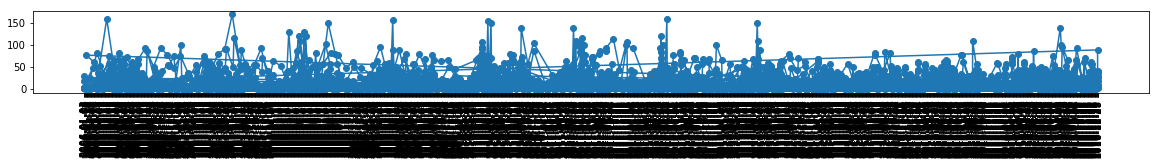

In [63]:
# Plotten chlfa waarden 2006 -2016
fig, ax = plt.subplots(figsize=(20,20), subplot_kw={'aspect':'equal'})

plt.scatter(df_chlfa['DATUM'],df_chlfa['WAARDE'])
plt.plot(df_chlfa['DATUM'],df_chlfa['WAARDE'])
plt.xticks(rotation=90)
plt.show()

### Seizoenspatroon zichtbaar & hoeveelheid chlfa lijkt af te nemen na 2/3 

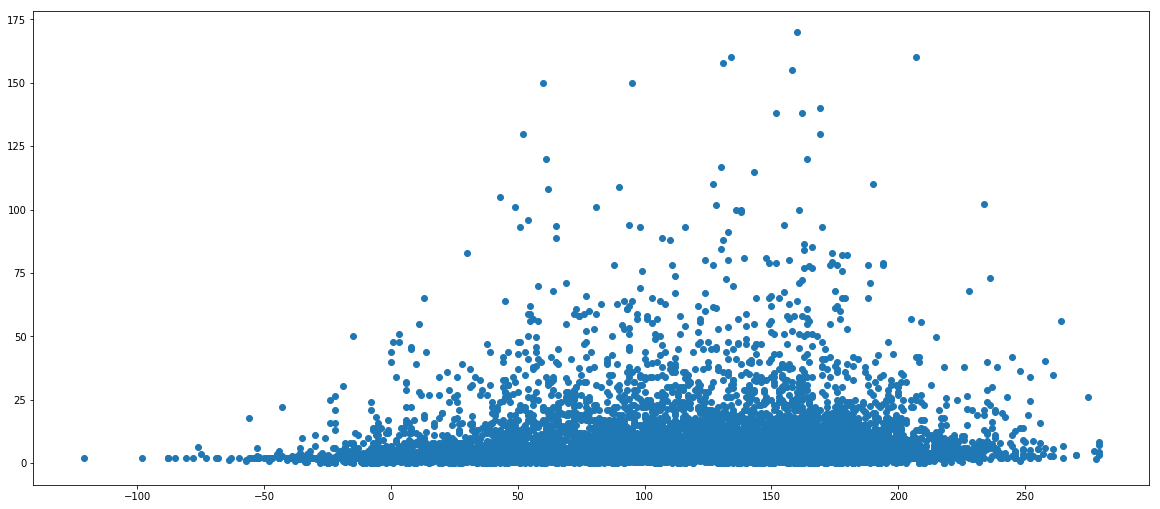

In [64]:
# Plotten chlfa(y) tegenover temperatuur(x)
fig, ax = plt.subplots(figsize=(20,50), subplot_kw={'aspect':'equal'})
plt.scatter(df_chlfa['TG'], df_chlfa['WAARDE'])
plt.show()

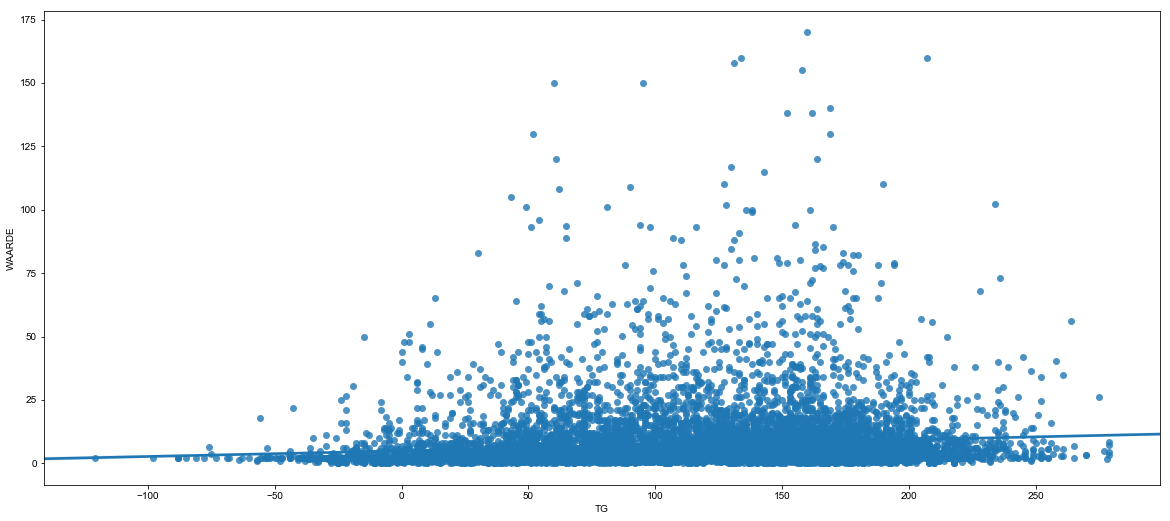

In [65]:
# Lijntje getrokken (met seaborn regplot)
fig, ax = plt.subplots(figsize=(20,50), subplot_kw={'aspect':'equal'})
sns.set(rc={"font.size":20,"axes.labelsize":20})
ax = sns.regplot(x='TG', y='WAARDE', data=df_chlfa)
plt.show()

In [66]:
# Plotten locaties Chlfa metingen met folium 

def color_producer(waarde):
    if waarde < 1000:
        return 'green'
    elif 1000 <= waarde< 3000:
        return 'orange'
    else:
        return 'red'
    
map = folium.Map(location=[52.29, 4.94], zoom_start=6, tiles="OpenStreetMap")

fg = folium.FeatureGroup(name="Locaties")

for lt, ln, name in zip(df_chlfa_group["Y_WGS"], df_chlfa_group["X_WGS"], df_chlfa_group['LOC']):
    fg.add_child(folium.Marker(location=[lt, ln], popup=name, icon=folium.Icon(color='red')))

   


map.add_child(fg)

map.save("mapi_osm.html")

In [67]:
print(df_chlfa_group['X_WGS'].mean(), df_chlfa_group['Y_WGS'].mean())

4.969633857142858 52.38027051020408


## Gerommel met cyanobacteriën

In [68]:
# Gemeten bacteriën: in totaal 28 metingen cyanobacteriën
df['BTXOMS'].value_counts()

Niet van toepassing               2298656
Thermo tolerante coli bacterie       3771
Coli bacterie                        1287
Escherichia coli                     1209
Streptococcus faecalis groep D        932
Enterococcacea                        910
Salmonella bacterie                   325
Microcystis                             7
Planktothrix                            7
Aphanizomenon                           7
Anabaena                                7
Name: BTXOMS, dtype: int64

In [69]:
# Dataframe met blauwalgen
df_algies = df[(df['BTXOMS'] == 'Anabaena') | (df['BTXOMS'] == 'Aphanizomenon') | 
             (df['BTXOMS'] == 'Microcystis') | (df['BTXOMS'] == 'Planktothrix')]
df_algies

knmi_STN       DATUM      LOC   TIJD        PAR  BGC    WAARDE  KWC  \
1077539     290.0  2011-05-09  ENSDVTS  '1020  AANTPVLME    <   22000.0    0   
1077540     290.0  2011-05-09  ENSDVTS  '1020  AANTPVLME    <   22000.0    0   
1077541     290.0  2011-05-09  ENSDVTS  '1020  AANTPVLME    <   22000.0    0   
1077542     290.0  2011-05-09  ENSDVTS  '1020  AANTPVLME    <   22000.0    0   
1077891     290.0  2011-06-08  ENSDVTS  '0930  AANTPVLME    <   22000.0    0   
1077892     290.0  2011-06-08  ENSDVTS  '0930  AANTPVLME    <   22000.0    0   
1077893     290.0  2011-06-08  ENSDVTS  '0930  AANTPVLME  NaN  181000.0    0   
1077894     290.0  2011-06-08  ENSDVTS  '0930  AANTPVLME    <   22000.0    0   
1078243     290.0  2011-07-04  ENSDVTS  '1120  AANTPVLME    <   22000.0    0   
1078244     290.0  2011-07-04  ENSDVTS  '1120  AANTPVLME    <   22000.0    0   
1078245     290.0  2011-07-04  ENSDVTS  '1120  AANTPVLME    <   22000.0    0   
1078246     290.0  2011-07-04  ENSDVTS  '1120  AANTPVLME    <   22000.0    0   
1078593     290.0  2011-08-01  ENSDVTS  '1000  AANTPVLME    <   22000.0    0   
1078594     290.0  2011-08-01  ENSDVTS  '1000  AANTPVLME    <   22000.0    0   
1078595     290.0  2011-08-01  ENSDVTS  '1000  AANTPVLME    <   22000.0    0   
1078596     290.0  2011-08-01  ENSDVTS  '1000  AANTPVLME    <   22000.0    0   
1078945     290.0  2011-08-29  ENSDVTS  '1030  AANTPVLME    <   22000.0    0   
1078946     290.0  2011-08-29  ENSDVTS  '1030  AANTPVLME  NaN   27000.0    0   
1078947     290.0  2011-08-29  ENSDVTS  '1030  AANTPVLME    <   22000.0    0   
1078948     290.0  2011-08-29  ENSDVTS  '1030  AANTPVLME    <   22000.0    0   
1079295     290.0  2011-09-26  ENSDVTS  '1030  AANTPVLME    <   22000.0    0   
1079296     290.0  2011-09-26  ENSDVTS  '1030  AANTPVLME    <   22000.0    0   
1079297     290.0  2011-09-26  ENSDVTS  '1030  AANTPVLME    <   22000.0    0   
1079298     290.0  2011-09-26  ENSDVTS  '1030  AANTPVLME    <   22000.0    0   
1079643     290.0  2011-10-24  ENSDVTS  '1005  AANTPVLME    <   22000.0    0   
1079644     290.0  2011-10-24  ENSDVTS  '1005  AANTPVLME    <   22000.0    0   
1079645     290.0  2011-10-24  ENSDVTS  '1005  AANTPVLME    <   22000.0    0   
1079646     290.0  2011-10-24  ENSDVTS  '1005  AANTPVLME    <   22000.0    0   

        EHD DOM    WNS  HDH     ANA  CPM BEM  BEW PLT:REFVLAK  PLT:BMH  SGK  \
1077539  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1077540  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1077541  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1077542  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1077891  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1077892  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1077893  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1077894  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1078243  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1078244  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1078245  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1078246  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1078593  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1078594  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1078595  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1078596  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1078945  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1078946  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1078947  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1078948  /l   E  744.0  NVT  N15204   10   S  NVT      WATSGL     -100  NVT   
1079295  /l   E  744.0  NVT  

## Dataframe preprocessing dmv selectie relevante variabelen & pivot

In [70]:
#  Relevante kolommen geselecteerd
df1 = df[["datum_tijd", "DATUM", "LOC", "GBD", "LOCOMS", "PAR", "PAROMS", "BTX", "WAARDE", "TG", "EHD", "HDH", "HDHOMS", "X_WGS", "Y_WGS", "X_RD", "Y_RD",
             "ANA", "ANAOMS", "BEM", "BEMOMS", "BTXOMS", "BTXCOD"]]
type(df)

pandas.core.frame.DataFrame

In [71]:
# Relevante variabelen uit kolommen selecteren, 
# beetje natte vingerwerk, google feature selection
df_cyan = df1[(df1['PAR'] == 'CHLFa') | (df1['PAR'] == 'P') | (df1['PAR'] == 'N') | (df1['PAR'] == 'NO3') | (df1['PAR'] == 'NH4') | 
             (df1['PAR'] == 'PO4') | (df1['PAR'] == 'NO2') | (df1['PAR'] == 'WINDSHD') | (df1['PAROMS'] == 'Kjeldahl stikstof') | 
             (df1['PAROMS'] == 'Zwevende stof') | (df1['PAR'] == 'ZS') | (df1['PAR'] == 'O2') | (df1['PAR'] == '%O2') |
             (df1['PAR'] == 'SALNTT') | (df1['PAR'] == 'Cl') | (df1['PAR'] == 'ZICHT') | (df1['PAR'] == 'pH') | 
             (df1['PAR'] == 'BaA') | (df1['PAR'] == 'SiO2') | (df1['PAR'] == 'Ra226') | (df1['PAR'] == '%GR') | 
             (df1['PAR'] == '%DS')]
              
            
df_cyan

datum_tijd       DATUM       LOC      GBD  \
1       2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
2       2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
3       2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
4       2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
5       2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
7       2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
10      2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
11      2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
12      2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
15      2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
17      2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
19      2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
21      2006-01-05 08:13:00  2006-01-05  WALCRN70  BREEVTN   
23      2006-01-10 02:11:00  2006-01-10   TERSLG4   WADDKT   
24      2006-01-10 02:11:00  2006-01-10   TERSLG4   WADDKT   
25      2006-01-10 02:11:00  2006-01-10   TERSLG4   WADDKT   
26      2006-01-10 02:11:00  2006-01-10   TERSLG4   WADDKT   
27      2006-01-10 02:11:00  2006-01-10   TERSLG4   WADDKT   
28      2006-01-10 02:11:00  2006-01-10   TERSLG4   WADDKT   
29      2006-01-10 02:11:00  2006-01-10   TERSLG4   WADDKT   
32      2006-01-10 02:11:00  2006-01-10   TERSLG4   WADDKT   
33      2006-01-10 02:11:00  2006-01-10   TERSLG4   WADDKT   
34      2006-01-10 02:11:00  2006-01-10   TERSLG4   WADDKT   
36      2006-01-10 02:11:00  2006-01-10   TERSLG4   WADDKT   
37      2006-01-10 02:11:00  2006-01-10   TERSLG4   WADDKT   
...                     ...         ...       ...      ...   
2344905 2016-11-16 12:30:00  2016-11-16   BELFBVN     MAAS   
2344906 2016-11-16 12:30:00  2016-11-16   BELFBVN     MAAS   
2344909 2016-11-16 12:30:00  2016-11-16   BELFBVN     MAAS   
2344912 2016-11-16 12:30:00  2016-11-16   BELFBVN     MAAS   
2344955 2016-11-16 12:30:00  2016-11-16   BELFBVN     MAAS   
2344957 2016-11-16 12:30:00  2016-11-16   BELFBVN     MAAS   
2344959 2016-11-16 12:30:00  2016-11-16   BELFBVN     MAAS   
2344978 2016-11-16 12:30:00  2016-11-16   BELFBVN     MAAS   
2344994 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2344995 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2344996 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2344997 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2344998 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2345158 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2345167 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2345171 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2345173 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2345174 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2345175 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2345178 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2345181 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2345240 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2345242 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2345244 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   
2345280 2016-12-14 12:30:00  2016-12-14   BELFBVN     MAAS   

                                LOCOMS      PAR               PAROMS  BTX  \
1          Walcheren 70 km uit de kust      NO2              nitriet  NVT   
2          Walcheren 70 km uit de kust      NH4             ammonium  NVT   
3          Walcheren 70 km uit de kust      PO4         orthofosfaat  NVT   
4          Walcheren 70 km uit de kust     SiO2             silicaat  NVT   
5          Walcheren 70 km uit de kust      NO3              nitraat  NVT   
7          Walcheren 70 km uit de kust    CHLFa          chlorofyl-a  NVT   
10         Walcheren 70 km uit de kust        N             stikstof  NVT   
11         Walcheren 70 km uit de kust       ZS        Zwevende stof  NVT   
12         Walcheren 70 km uit de kust        N             stikstof  NVT   
15         Walcheren 7

In [72]:
# Kijken naar percentage missende waarden in de X_WGS en Y_WGS kolommen, aangezien die het coördinatensysteem hebben dat het 
# meest geschikt is om te plotten
df_cyan[['X_WGS', 'Y_WGS']].isnull().sum() / df_cyan.shape[0] * 100

X_WGS    1.201987
Y_WGS    1.201987
dtype: float64

In [73]:
# Dataframe naar csv
df_cyan.to_csv('df_klein_long.csv')

In [74]:
df_cyan.shape

(245011, 23)

In [75]:
# Df nog maar 35 MB
df_cyan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245011 entries, 1 to 2345280
Data columns (total 23 columns):
datum_tijd    245011 non-null datetime64[ns]
DATUM         245011 non-null object
LOC           245011 non-null object
GBD           245011 non-null object
LOCOMS        245011 non-null object
PAR           245011 non-null object
PAROMS        245011 non-null object
BTX           245011 non-null object
WAARDE        245011 non-null float64
TG            223482 non-null float64
EHD           245011 non-null object
HDH           245011 non-null object
HDHOMS        245011 non-null object
X_WGS         242066 non-null float64
Y_WGS         242066 non-null float64
X_RD          244292 non-null float64
Y_RD          244292 non-null float64
ANA           245011 non-null object
ANAOMS        245011 non-null object
BEM           245011 non-null object
BEMOMS        245011 non-null object
BTXOMS        245011 non-null object
BTXCOD        245011 non-null object
dtypes: datetime64[ns](

In [76]:
# Dataframe naar wide, relevante variabelen per hoedanigheid in kolom
df_cyan_wide1 = df_cyan.pivot_table(index=["datum_tijd","DATUM", "LOC", "GBD", "LOCOMS", "PAROMS", "BTX", "TG", "EHD", "HDHOMS", "X_WGS", "Y_WGS", "X_RD", "Y_RD",
             "ANA", "ANAOMS"], columns=['PAR', 'HDH'], values='WAARDE')

# 
df_cyan_wide1.columns = ['_HDH_'.join(col).strip() for col in df_cyan_wide1.columns.values]

# Herstellen index
df_cyan_wide = df_cyan_wide1.reset_index()
df_cyan_wide

datum_tijd       DATUM          LOC         GBD  \
0      2006-01-02 06:30:00  2006-01-02       SASVGT  KANVGNTNZN   
1      2006-01-02 06:30:00  2006-01-02       SASVGT  KANVGNTNZN   
2      2006-01-02 08:15:00  2006-01-02     STEENBGN    VOLKRZMR   
3      2006-01-02 08:15:00  2006-01-02     STEENBGN    VOLKRZMR   
4      2006-01-02 08:20:00  2006-01-02       PUTTHK       OUDMS   
5      2006-01-02 08:20:00  2006-01-02       PUTTHK       OUDMS   
6      2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
7      2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
8      2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
9      2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
10     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
11     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
12     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
13     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
14     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
15     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
16     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
17     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
18     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
19     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
20     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
21     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
22     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
23     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS   
24     2006-01-02 11:40:00  2006-01-02     EEMMDK23       EEMMR   
...                    ...         ...          ...         ...   
222780 2016-12-29 09:23:00  2016-12-29  SCHAARVODDL     SCHELDE   
222781 2016-12-29 09:23:00  2016-12-29  SCHAARVODDL     SCHELDE   
222782 2016-12-29 09:23:00  2016-12-29  SCHAARVODDL     SCHELDE   
222783 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222784 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222785 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222786 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222787 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222788 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222789 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222790 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222791 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222792 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222793 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222794 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222795 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222796 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222797 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222798 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222799 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222800 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222801 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222802 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222803 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   
222804 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE   

                                 LOCOMS                 PAROMS  BTX    TG  \
0                          Sas van Gent  Percentage droge stof  NVT  17.0   
1                          Sas van Gent      benzo(a)antraceen  NVT  17.0   
2       Steenbergen (Roosendaalsevliet)  Percentage droge stof  NVT  -2.0   
3       Steenbergen (Roosendaalsevliet)      benzo(a)antraceen  NVT  -2.0   
4                           Puttershoek  Percentage droge stof  NVT  18.0   
5                           Puttershoek      benzo(a)antraceen  NVT  

In [77]:
df_cyan_wide.shape

(222805, 47)

In [78]:
# Dataframe geschikter maken voor analyse door kolommen met omschrijvingen te schrappen
df_PAR_wide = df_cyan.pivot_table(index=["datum_tijd","DATUM", "LOC", "GBD", "TG", "X_WGS", "Y_WGS", "X_RD", "Y_RD",
             "ANA"], columns=['PAR', 'HDH'], values='WAARDE')

df_PAR_wide.columns = ['_HDH_'.join(col).strip() for col in df_PAR_wide.columns.values]
df_PAR_wide = df_PAR_wide.reset_index()
df_PAR_wide

datum_tijd       DATUM          LOC         GBD    TG  \
0      2006-01-02 06:30:00  2006-01-02       SASVGT  KANVGNTNZN  17.0   
1      2006-01-02 06:30:00  2006-01-02       SASVGT  KANVGNTNZN  17.0   
2      2006-01-02 08:15:00  2006-01-02     STEENBGN    VOLKRZMR  -2.0   
3      2006-01-02 08:15:00  2006-01-02     STEENBGN    VOLKRZMR  -2.0   
4      2006-01-02 08:20:00  2006-01-02       PUTTHK       OUDMS  18.0   
5      2006-01-02 08:20:00  2006-01-02       PUTTHK       OUDMS  18.0   
6      2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS  18.0   
7      2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS  18.0   
8      2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS  18.0   
9      2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS  18.0   
10     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS  18.0   
11     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS  18.0   
12     2006-01-02 09:35:00  2006-01-02       PUTTHK       OUDMS  18.0   
13     2006-01-02 11:40:00  2006-01-02     EEMMDK23       EEMMR   9.0   
14     2006-01-02 11:40:00  2006-01-02     EEMMDK23       EEMMR   9.0   
15     2006-01-02 11:40:00  2006-01-02     EEMMDK23       EEMMR   9.0   
16     2006-01-02 11:40:00  2006-01-02     EEMMDK23       EEMMR   9.0   
17     2006-01-02 11:40:00  2006-01-02     EEMMDK23       EEMMR   9.0   
18     2006-01-02 11:40:00  2006-01-02     EEMMDK23       EEMMR   9.0   
19     2006-01-02 11:45:00  2006-01-02     EEMMDK23       EEMMR   9.0   
20     2006-01-02 11:45:00  2006-01-02     EEMMDK23       EEMMR   9.0   
21     2006-01-02 13:52:00  2006-01-02        BOVSS      HOLLDP  18.0   
22     2006-01-02 13:52:00  2006-01-02        BOVSS      HOLLDP  18.0   
23     2006-01-02 13:52:00  2006-01-02        BOVSS      HOLLDP  18.0   
24     2006-01-02 13:52:00  2006-01-02        BOVSS      HOLLDP  18.0   
...                    ...         ...          ...         ...   ...   
116610 2016-12-29 07:45:00  2016-12-29  SCHAARVODDL     SCHELDE  -7.0   
116611 2016-12-29 07:45:00  2016-12-29  SCHAARVODDL     SCHELDE  -7.0   
116612 2016-12-29 09:23:00  2016-12-29  SCHAARVODDL     SCHELDE  -7.0   
116613 2016-12-29 09:23:00  2016-12-29  SCHAARVODDL     SCHELDE  -7.0   
116614 2016-12-29 09:23:00  2016-12-29  SCHAARVODDL     SCHELDE  -7.0   
116615 2016-12-29 09:23:00  2016-12-29  SCHAARVODDL     SCHELDE  -7.0   
116616 2016-12-29 09:23:00  2016-12-29  SCHAARVODDL     SCHELDE  -7.0   
116617 2016-12-29 09:23:00  2016-12-29  SCHAARVODDL     SCHELDE  -7.0   
116618 2016-12-29 09:23:00  2016-12-29  SCHAARVODDL     SCHELDE  -7.0   
116619 2016-12-29 09:23:00  2016-12-29  SCHAARVODDL     SCHELDE  -7.0   
116620 2016-12-29 09:23:00  2016-12-29  SCHAARVODDL     SCHELDE  -7.0   
116621 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116622 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116623 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116624 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116625 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116626 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116627 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116628 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116629 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116630 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116631 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116632 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116633 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   
116634 2016-12-29 13:00:00  2016-12-29    TERNZBI20     WESTSDE -11.0   

           X_WGS     Y_WGS      X_RD      Y_RD       ANA  %DS_HDH_NVT  \
0       3.802218  51.21029   44250.0  359080.0     W5352          NaN   
1       3.802218  51.21029   44250.0  359080.0     W7002         32.0   


In [79]:
# Kijken naar percentage missende waarden in de X_WGS en Y_WGS kolommen, aangezien die het coördinatensysteem hebben dat het 
# meest geschikt is om te plotten
df_PAR_wide[['X_WGS', 'Y_WGS']].isnull().sum() / df_PAR_wide.shape[0] * 100

X_WGS    0.0
Y_WGS    0.0
dtype: float64

In [80]:
# Grouperen op datum en lokatie, datetime waarden onbetrouwbaar, 
df_PAR_loc = df_PAR_wide.groupby(['DATUM', 'LOC', 'GBD']).mean()
df_PAR_loc

TG     X_WGS     Y_WGS      X_RD  \
DATUM      LOC          GBD                                               
2006-01-02 BOVSS        HOLLDP       18.0  4.493381  51.69246   93200.0   
           EEMMDK23     EEMMR         9.0  5.355114  52.27875  152810.0   
           PUTTHK       OUDMS        18.0  4.565993  51.81165   98370.0   
           SASVGT       KANVGNTNZN   17.0  3.802218  51.21029   44250.0   
           STEENBGN     VOLKRZMR     -2.0  4.242284  51.64120   75750.0   
2006-01-03 EIJSDPTN     MAAS         -4.0  5.699107  50.77950  177000.0   
           HARVSS       HARVT        23.0  4.058326  51.82947   63400.0   
           SASVGT       KANVGNTNZN    5.0  3.802218  51.21029   44250.0   
           STEENBGN     VOLKRZMR    -10.0  4.242284  51.64120   75750.0   
           VELWMMDN     VELWMR        6.0  5.677842  52.40065  174780.0   
           WOLDWMDN     WOLDWD        6.0  5.567859  52.34982  167309.0   
2006-01-04 KETMWT       KETMR        10.0  5.642022  52.61039  172260.0   
           LOBPTN       RIJN         10.0  6.091178  51.85421  203500.0   
2006-01-05 GOERE6       VOORDTA       8.0  3.873397  51.86877   50745.0   
           HEEL         LATKNLNBGNM   7.0  5.927160  51.18757  192750.0   
           SCHOUWN10    VOORDTA      11.0  3.495110  51.71907   24263.0   
           WALCRN2      VOORDTA      11.0  3.410673  51.54797   17913.0   
           WALCRN20     VOORDTA      11.0  3.220431  51.65769    5084.0   
2006-01-06 DANTZGT      WADDZOT       8.0  5.726981  53.40114  177600.0   
2006-01-09 HANSWGL      WESTSDE      13.0  4.014149  51.43611   59530.0   
           HOEDKKKBI4   WESTSDE      13.0  3.920581  51.42509   53000.0   
           TERNZBI20    WESTSDE      14.0  3.825487  51.34654   46200.0   
           VLISSGBISSVH WESTSDE      27.0  3.565619  51.41199   28280.0   
           ZOUTKPLG     WADDZOT     -14.0  6.132651  53.42941  204550.0   
           ZOUTKPLZGT   WADDZOT     -14.0  6.079226  53.47510  200950.0   
...                                   ...       ...       ...       ...   
2016-12-19 EIJSDPTN     MAAS         39.0  5.699107  50.77950  177000.0   
           NOORDWK70    BREEVTN      50.0  3.545362  52.56620   30127.0   
           PAMPOT       IJMR         43.0  5.087658  52.36648  134598.0   
2016-12-20 EIJSDPTN     MAAS          1.0  5.699107  50.77950  177000.0   
           KAMPN        IJSSL        -1.0  5.917924  52.55897  190990.0   
           REVE         DRONTMR      -1.0  5.860605  52.51786  187133.0   
           SASVGT       KANVGNTNZN   14.0  3.802218  51.21029   44250.0   
           TERSLG10     WADDKT       13.0  5.100445  53.45997  135952.0   
           TERSLG50     FRIESFT      15.0  4.766609  53.76632  114072.0   
           VELWMMDN     VELWMR       -7.0  5.677842  52.40065  174780.0   
2016-12-21 GENMDN       ZWARTWTR     37.0  6.038557  52.62928  199100.0   
           KETMWT       KETMR        38.0  5.642022  52.61039  172260.0   
           LOBPTN       RIJN         34.0  6.091178  51.85421  203500.0   
           RAMSDP       ZWARTMR      37.0  5.931705  52.63006  191865.0   
2016-12-22 BOVSS        HOLLDP       60.0  4.493381  51.69246   93200.0   
           HARVSS       HARVT        61.0  4.058326  51.82947   63400.0   
           PUTTHK       OUDMS        60.0  4.565993  51.81165   98370.0   
2016-12-27 EIJSDPTN     MAAS         30.0  5.699107  50.77950  177000.0   
           HOUTRHK      IJSSMR       65.0  5.472736  52.56048  160800.0   
           STEILBK      IJSSMR       65.0  5.629536  52.82810  171333.0   
           VROUWZD      IJSSMR       65.0  5.393138  52.81035  155400.0   
2016-12-28 HOORNSHP     MARKMR       19.0  5.062389  52.61309  133000.0   
           MARKGZE      MARKMR       19.0  5.085581  52.46037  134500.0   
2016-12-29 SCHAARVODDL  SCHELDE      -7.0  4.250659  51.35029   75825.0   
           TERNZBI20    WESTSDE     -11.0  3.825487  51.34654   46200.0   

                                         Y_RD  %DS_HDH_NVT  %GR

In [81]:
df_PAR_loc.reset_index(level=['GBD'], inplace=True)

In [82]:
# Percentage missende waarden per kolom
df_PAR_loc.isnull().sum() / df_PAR_loc.shape[0] * 100

GBD                 0.000000
TG                  0.000000
X_WGS               0.000000
Y_WGS               0.000000
X_RD                0.000000
Y_RD                0.000000
%DS_HDH_NVT        81.285444
%GR_HDH_NVT        69.521594
%O2_HDH_NVT        17.725753
BaA_HDH_NVT        56.805293
BaA_HDH_dg         79.904028
CHLFa_HDH_NVT      17.231351
Cl_HDH_NVT         99.985459
Cl_HDH_nf          41.209830
KjN_HDH_N          53.090010
KjN_HDH_Ndg        89.581213
N_HDH_NVT          58.310310
N_HDH_nf           59.320925
N_HDH_pg           57.248800
NH4_HDH_Nnf        12.679948
NO2_HDH_Nnf        11.967428
NO3_HDH_Nnf        11.182202
O2_HDH_NVT         12.432747
P_HDH_NVT          13.668751
P_HDH_dg           88.163443
P_HDH_nf           58.710193
P_HDH_pg           57.975862
PO4_HDH_Pnf        11.931075
Ra226_HDH_NVT      94.605206
Ra226_HDH_dg       99.549222
SALNTT_HDH_NVT     25.636179
SiO2_HDH_Sinf      13.683292
SiO2_HDH_Sipg      98.836702
WINDSHD_HDH_NVT    28.195434
ZICHT_HDH_NVT 

In [83]:
# Selecteren rijen met niet-nul waarden van relevante variabelen in welke hoedanigheid dan ook, teneinde rijen met meting voor 
# elke variabele te hebben
df_RWS = df_PAR_loc[(df_PAR_loc['CHLFa_HDH_NVT'].notnull()) & (df_PAR_loc['KjN_HDH_N'].notnull() | df_PAR_loc['N_HDH_NVT'].notnull() |
                                                     df_PAR_loc['NH4_HDH_Nnf'].notnull()) & (df_PAR_loc['P_HDH_NVT'].notnull() |
                                                       df_PAR_loc['PO4_HDH_Pnf'].notnull()) & (df_PAR_loc['WINDSHD_HDH_NVT'].notnull())]

df_RWS.head()

GBD    TG     X_WGS     Y_WGS      X_RD      Y_RD  \
DATUM      LOC                                                              
2006-01-02 BOVSS     HOLLDP  18.0  4.493381  51.69246   93200.0  411900.0   
           EEMMDK23   EEMMR   9.0  5.355114  52.27875  152810.0  476750.0   
           PUTTHK     OUDMS  18.0  4.565993  51.81165   98370.0  425100.0   
2006-01-03 EIJSDPTN    MAAS  -4.0  5.699107  50.77950  177000.0  310000.0   
           HARVSS     HARVT  23.0  4.058326  51.82947   63400.0  427600.0   

                     %DS_HDH_NVT  %GR_HDH_NVT  %O2_HDH_NVT  BaA_HDH_NVT  \
DATUM      LOC                                                            
2006-01-02 BOVSS             NaN         83.0         87.0         0.01   
           EEMMDK23         23.0         65.0         94.0          NaN   
           PUTTHK           35.0         81.0         88.0         0.01   
2006-01-03 EIJSDPTN         40.0         71.0         99.2          NaN   
           HARVSS           28.0         82.0         95.0         0.01   

                     BaA_HDH_dg  CHLFa_HDH_NVT  Cl_HDH_NVT  Cl_HDH_nf  \
DATUM      LOC                                                          
2006-01-02 BOVSS            NaN            2.0         NaN      101.7   
           EEMMDK23        0.21            3.0         NaN       81.5   
           PUTTHK          0.43            2.0         NaN      101.4   
2006-01-03 EIJSDPTN        1.00            2.0         NaN       50.1   
           HARVSS          0.73            3.0         NaN      272.5   

                     KjN_HDH_N  KjN_HDH_Ndg  N_HDH_NVT  N_HDH_nf  N_HDH_pg  \
DATUM      LOC                                                               
2006-01-02 BOVSS          0.64          NaN        NaN       NaN       NaN   
           EEMMDK23       1.60          NaN        NaN       NaN       NaN   
           PUTTHK         0.32          NaN        NaN       NaN       NaN   
2006-01-03 EIJSDPTN       0.92      11000.0        NaN       NaN       NaN   
           HARVSS         0.53          NaN        NaN       NaN       NaN   

                     NH4_HDH_Nnf  NO2_HDH_Nnf  NO3_HDH_Nnf  O2_HDH_NVT  \
DATUM      LOC                                                           
2006-01-02 BOVSS            0.13         0.03         3.79        10.3   
           EEMMDK23         0.59         0.04         2.15        13.3   
           PUTTHK           0.13         0.03         3.85        10.6   
2006-01-03 EIJSDPTN         0.30         0.06         4.22        12.3   
           HARVSS           0.14         0.02         2.97        11.7   

                     P_HDH_NVT  P_HDH_dg  P_HDH_nf  P_HDH_pg  PO4_HDH_Pnf  \
DATUM      LOC                                                              
2006-01-02 BOVSS          0.30       NaN       NaN       NaN        0.100   
           EEMMDK23       0.17       NaN       NaN       NaN        0.085   
           PUTTHK         0.13       NaN       NaN       NaN        0.100   
2006-01-03 EIJSDPTN       0.22       4.8       NaN       NaN        0.150   
           HARVSS         0.16       NaN       NaN       NaN        0.120   

                     Ra226_HDH_NVT  Ra226_HDH_dg  SALNTT_HDH_NVT  \
DATUM      LOC                                                     
2006-01-02 BOVSS               NaN           NaN             0.3   
           EEMMDK23            NaN           NaN             NaN   
           PUTTHK              NaN           NaN             0.3   
2006-01-03 EIJSDPTN            NaN           NaN             NaN   
           HARVSS              NaN           NaN             0.7   

                     SiO2_HDH_Sinf  SiO2_HDH_Sipg  WINDSHD_HDH_NVT  \
DATUM      LOC                                                       
2006-01-02 BOVSS              3.65            NaN              4.0   
           EEMMDK23           5.70            NaN              3.0   
           PUTTHK             3.64            NaN              4.0   
2006-01-03 EI

In [84]:
df_RWS.reset_index(inplace=True)
df_RWS

DATUM          LOC         GBD    TG     X_WGS     Y_WGS      X_RD  \
0     2006-01-02        BOVSS      HOLLDP  18.0  4.493381  51.69246   93200.0   
1     2006-01-02     EEMMDK23       EEMMR   9.0  5.355114  52.27875  152810.0   
2     2006-01-02       PUTTHK       OUDMS  18.0  4.565993  51.81165   98370.0   
3     2006-01-03     EIJSDPTN        MAAS  -4.0  5.699107  50.77950  177000.0   
4     2006-01-03       HARVSS       HARVT  23.0  4.058326  51.82947   63400.0   
5     2006-01-03       SASVGT  KANVGNTNZN   5.0  3.802218  51.21029   44250.0   
6     2006-01-03     STEENBGN    VOLKRZMR -10.0  4.242284  51.64120   75750.0   
7     2006-01-03     VELWMMDN      VELWMR   6.0  5.677842  52.40065  174780.0   
8     2006-01-03     WOLDWMDN      WOLDWD   6.0  5.567859  52.34982  167309.0   
9     2006-01-04       KETMWT       KETMR  10.0  5.642022  52.61039  172260.0   
10    2006-01-04       LOBPTN        RIJN  10.0  6.091178  51.85421  203500.0   
11    2006-01-10  SCHAARVODDL     SCHELDE  23.0  4.250659  51.35029   75825.0   
12    2006-01-10      VROUWZD      IJSSMR  20.0  5.393138  52.81035  155400.0   
13    2006-01-11       MAASSS   NIEUWWTWG  46.0  4.249788  51.91751   76750.0   
14    2006-01-16        WIENE    TWENTKNL   3.0  6.650719  52.24009  241300.0   
15    2006-01-17      BELFBVN        MAAS  41.0  6.113325  51.31860  205620.0   
16    2006-01-17     EIJSDPTN        MAAS  48.0  5.699107  50.77950  177000.0   
17    2006-01-17       GENMDN    ZWARTWTR  33.0  6.038557  52.62928  199100.0   
18    2006-01-17        KAMPN       IJSSL  33.0  5.917924  52.55897  190990.0   
19    2006-01-17       KEIZVR     BERGSMS  57.0  4.894437  51.72019  120950.0   
20    2006-01-17        NEDWT    ZUIDWLVT  50.0  5.749750  51.27239  180300.0   
21    2006-01-17       STEVWT        MAAS  50.0  5.841665  51.13109  186812.0   
22    2006-01-18       LOBPTN        RIJN  27.0  6.091178  51.85421  203500.0   
23    2006-01-24      BRIENOD     NIEUWMS -18.0  4.525587  51.89990   95700.0   
24    2006-01-24     GOUDVHVN   HOLLSIJSL -24.0  4.691184  51.99672  107200.0   
...          ...          ...         ...   ...       ...       ...       ...   
9075  2016-12-14     WALCRN20     VOORDTA  74.0  3.220431  51.65769    5084.0   
9076  2016-12-14       WESTZN   NOORDZKNL  74.0  4.764255  52.42782  112630.0   
9077  2016-12-15      DOOVBWT     WADDZWT  65.0  5.032264  53.05290  131200.0   
9078  2016-12-15       MAASSS   NIEUWWTWG  58.0  4.249788  51.91751   76750.0   
9079  2016-12-15      MARSDND     WADDZWT  64.0  4.749934  52.98254  112200.0   
9080  2016-12-19       PAMPOT        IJMR  43.0  5.087658  52.36648  134598.0   
9081  2016-12-20     EIJSDPTN        MAAS   1.0  5.699107  50.77950  177000.0   
9082  2016-12-20        KAMPN       IJSSL  -1.0  5.917924  52.55897  190990.0   
9083  2016-12-20         REVE     DRONTMR  -1.0  5.860605  52.51786  187133.0   
9084  2016-12-20       SASVGT  KANVGNTNZN  14.0  3.802218  51.21029   44250.0   
9085  2016-12-20     VELWMMDN      VELWMR  -7.0  5.677842  52.40065  174780.0   
9086  2016-12-21       GENMDN    ZWARTWTR  37.0  6.038557  52.62928  199100.0   
9087  2016-12-21       KETMWT       KETMR  38.0  5.642022  52.61039  172260.0   
9088  2016-12-21       LOBPTN        RIJN  34.0  6.091178  51.85421  203500.0   
9089  2016-12-21       RAMSDP     ZWARTMR  37.0  5.931705  52.63006  191865.0   
9090  2016-12-22        BOVSS      HOLLDP  60.0  4.493381  51.69246   93200.0   
9091  2016-12-22       HARVSS       HARVT  61.0  4.058326  51.82947   63400.0   
9092  2016-12-22       PUTTHK       OUDMS  60.0  4.565993  51.81165   98370.0   
9093  2016-12-27      HOUTRHK      IJSSMR  65.0  5.472736  52.56048  160800.0   
9094  2016-12-27      STEILBK      IJSSMR  65.0  5.629536  52.82810  171333.0   
9095  2016-12-27      VROUWZD      IJSSMR  65.0  5.393138  52.81035  155400.0   
9096  2016-12-28     HOORNSHP      MARKMR  19.0  5.062389  52.61309  133000.0   
9097  2016-12-28      MARKGZE      MARKMR 

In [85]:
# Verwijder kolommen met meer dan x% NaN's en sla df op
df_rws = df_RWS.drop(['KjN_HDH_Ndg', 'P_HDH_dg', 'Cl_HDH_NVT'], axis=1)

df_rws.to_csv('df_rws.csv')

df_rws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9100 entries, 0 to 9099
Data columns (total 36 columns):
DATUM              9100 non-null object
LOC                9100 non-null object
GBD                9100 non-null object
TG                 9100 non-null float64
X_WGS              9100 non-null float64
Y_WGS              9100 non-null float64
X_RD               9100 non-null float64
Y_RD               9100 non-null float64
%DS_HDH_NVT        1632 non-null float64
%GR_HDH_NVT        3505 non-null float64
%O2_HDH_NVT        8690 non-null float64
BaA_HDH_NVT        4702 non-null float64
BaA_HDH_dg         1674 non-null float64
CHLFa_HDH_NVT      9100 non-null float64
Cl_HDH_nf          6381 non-null float64
KjN_HDH_N          4966 non-null float64
N_HDH_NVT          4242 non-null float64
N_HDH_nf           4062 non-null float64
N_HDH_pg           4296 non-null float64
NH4_HDH_Nnf        8879 non-null float64
NO2_HDH_Nnf        9056 non-null float64
NO3_HDH_Nnf        9061 non-null fl

#### Selecteer en visualiseer locaties in een bepaald stroomgebied: Noordzeekanaal

In [86]:
df_nrdzee = df_RWS.query('GBD == "NOORDZKNL"')
df_nrdzee.head(10)

DATUM     LOC        GBD     TG     X_WGS     Y_WGS      X_RD  \
27   2006-01-26   AMSDM  NOORDZKNL   14.0  4.905707  52.38077  122216.0   
28   2006-01-26  IJMDN1  NOORDZKNL   13.0  4.622005  52.46601  103000.0   
56   2006-02-23   AMSDM  NOORDZKNL    8.0  4.905707  52.38077  122216.0   
57   2006-02-23  IJMDN1  NOORDZKNL    5.0  4.622005  52.46601  103000.0   
86   2006-03-23   AMSDM  NOORDZKNL   36.0  4.905707  52.38077  122216.0   
87   2006-03-23  IJMDN1  NOORDZKNL   32.0  4.622005  52.46601  103000.0   
115  2006-04-20   AMSDM  NOORDZKNL  116.0  4.905707  52.38077  122216.0   
116  2006-04-20  IJMDN1  NOORDZKNL  104.0  4.622005  52.46601  103000.0   
143  2006-05-18   AMSDM  NOORDZKNL  158.0  4.905707  52.38077  122216.0   
144  2006-05-18  IJMDN1  NOORDZKNL  141.0  4.622005  52.46601  103000.0   

         Y_RD  %DS_HDH_NVT  %GR_HDH_NVT  %O2_HDH_NVT  BaA_HDH_NVT  BaA_HDH_dg  \
27   488210.0          NaN         92.0        100.0          NaN         NaN   
28   497860.0          NaN         86.0        104.0         0.01         NaN   
56   488210.0          NaN         78.0         89.0          NaN         NaN   
57   497860.0          NaN         82.0          NaN         0.01         NaN   
86   488210.0          NaN         58.0        102.0          NaN         NaN   
87   497860.0          NaN         58.0         99.0         0.02         NaN   
115  488210.0          NaN         74.0         61.0          NaN         NaN   
116  497860.0          NaN         66.0         69.0         0.02         NaN   
143  488210.0          NaN         73.0         83.0          NaN         NaN   
144  497860.0          NaN         66.0        113.0         0.04         NaN   

     CHLFa_HDH_NVT  Cl_HDH_NVT  Cl_HDH_nf  KjN_HDH_N  KjN_HDH_Ndg  N_HDH_NVT  \
27             3.0         NaN        NaN       0.81          NaN        NaN   
28             2.0         NaN     4921.0       0.71          NaN        NaN   
56            13.0         NaN     1821.0       0.96          NaN        NaN   
57             3.0         NaN     3981.0       0.96          NaN        NaN   
86            11.0         NaN     1399.0       1.30          NaN        NaN   
87            16.0         NaN     3823.0       1.20          NaN        NaN   
115           18.0         NaN      944.9       1.70          NaN        NaN   
116           20.0         NaN     3967.0       1.20          NaN        NaN   
143           12.0         NaN     2097.0       0.64          NaN        NaN   
144           40.0         NaN     4238.0       0.62          NaN        NaN   

     N_HDH_nf  N_HDH_pg  NH4_HDH_Nnf  NO2_HDH_Nnf  NO3_HDH_Nnf  O2_HDH_NVT  \
27        NaN       NaN          NaN          NaN          NaN        12.9   
28        NaN       NaN         0.41         0.14         1.71        12.2   
56        NaN       NaN         0.23         0.09         2.29         8.7   
57        NaN       NaN         0.32         0.15         3.12         9.4   
86        NaN       NaN         0.16         0.06         2.09        13.1   
87        NaN       NaN         0.14         0.12         2.33        12.2   
115       NaN       NaN         0.07         0.05         2.20         6.7   
116       NaN       NaN          NaN         0.07         2.37         7.3   
143       NaN       NaN         0.09         0.05         1.12         7.8   
144       NaN       NaN         0.06         0.07         1.29        10.3   

     P_HDH_NVT  P_HDH_dg  P_HDH_nf  P_HDH_pg  PO4_HDH_Pnf  Ra226_HDH_NVT  \
27        0.18       NaN       NaN       NaN          NaN            NaN   
28        0.25       NaN       NaN       NaN        0.210            NaN   
56        0.16       NaN       NaN       NaN        0.087            NaN   
57        0.23       NaN       NaN       NaN        0.170            NaN   
86        0.10       NaN       NaN       NaN        0.071            NaN   
87        0.10       NaN       NaN       NaN        0.120            NaN   
115       0.21      

In [87]:
df_nrdzee['DATUM'] = df_nrdzee['DATUM'].str.slice(0, 7)

df_nrdzee.head()

C:\Users\Andries Jan\anacond\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


DATUM     LOC        GBD    TG     X_WGS     Y_WGS      X_RD      Y_RD  \
27  2006-01   AMSDM  NOORDZKNL  14.0  4.905707  52.38077  122216.0  488210.0   
28  2006-01  IJMDN1  NOORDZKNL  13.0  4.622005  52.46601  103000.0  497860.0   
56  2006-02   AMSDM  NOORDZKNL   8.0  4.905707  52.38077  122216.0  488210.0   
57  2006-02  IJMDN1  NOORDZKNL   5.0  4.622005  52.46601  103000.0  497860.0   
86  2006-03   AMSDM  NOORDZKNL  36.0  4.905707  52.38077  122216.0  488210.0   

    %DS_HDH_NVT  %GR_HDH_NVT  %O2_HDH_NVT  BaA_HDH_NVT  BaA_HDH_dg  \
27          NaN         92.0        100.0          NaN         NaN   
28          NaN         86.0        104.0         0.01         NaN   
56          NaN         78.0         89.0          NaN         NaN   
57          NaN         82.0          NaN         0.01         NaN   
86          NaN         58.0        102.0          NaN         NaN   

    CHLFa_HDH_NVT  Cl_HDH_NVT  Cl_HDH_nf  KjN_HDH_N  KjN_HDH_Ndg  N_HDH_NVT  \
27            3.0         NaN        NaN       0.81          NaN        NaN   
28            2.0         NaN     4921.0       0.71          NaN        NaN   
56           13.0         NaN     1821.0       0.96          NaN        NaN   
57            3.0         NaN     3981.0       0.96          NaN        NaN   
86           11.0         NaN     1399.0       1.30          NaN        NaN   

    N_HDH_nf  N_HDH_pg  NH4_HDH_Nnf  NO2_HDH_Nnf  NO3_HDH_Nnf  O2_HDH_NVT  \
27       NaN       NaN          NaN          NaN          NaN        12.9   
28       NaN       NaN         0.41         0.14         1.71        12.2   
56       NaN       NaN         0.23         0.09         2.29         8.7   
57       NaN       NaN         0.32         0.15         3.12         9.4   
86       NaN       NaN         0.16         0.06         2.09        13.1   

    P_HDH_NVT  P_HDH_dg  P_HDH_nf  P_HDH_pg  PO4_HDH_Pnf  Ra226_HDH_NVT  \
27       0.18       NaN       NaN       NaN          NaN            NaN   
28       0.25       NaN       NaN       NaN        0.210            NaN   
56       0.16       NaN       NaN       NaN        0.087            NaN   
57       0.23       NaN       NaN       NaN        0.170            NaN   
86       0.10       NaN       NaN       NaN        0.071            NaN   

    Ra226_HDH_dg  SALNTT_HDH_NVT  SiO2_HDH_Sinf  SiO2_HDH_Sipg  \
27           NaN             NaN            NaN            NaN   
28           NaN             9.5           3.72            NaN   
56           NaN             NaN           3.01            NaN   
57           NaN             7.5           3.85            NaN   
86           NaN             NaN           2.49            NaN   

    WINDSHD_HDH_NVT  ZICHT_HDH_NVT  ZS_HDH_NVT  pH_HDH_NVT  
27              4.0            9.0         8.0         7.8  
28              8.0           13.0         8.0         7.7  
56              3.0            8.0        16.0         7.8  
57              2.0           13.0         8.0         7.7  
86              4.0            7.0        15.0         7.9

In [88]:
df_nrdzee['LOC'].value_counts()

IJMDN1      137
AMSDM       136
WESTZN       89
AMRKHVN2     23
WESTHVN2     23
ZIJKNLE2     12
ZIJKNLD1     12
Name: LOC, dtype: int64

In [89]:
df_nrdzee = df_nrdzee.groupby(['DATUM']).mean()
df_nrdzee.head()

TG     X_WGS     Y_WGS      X_RD      Y_RD  %DS_HDH_NVT  \
DATUM                                                                 
2006-01   13.5  4.763856  52.42339  112608.0  493035.0          NaN   
2006-02    6.5  4.763856  52.42339  112608.0  493035.0          NaN   
2006-03   34.0  4.763856  52.42339  112608.0  493035.0          NaN   
2006-04  110.0  4.763856  52.42339  112608.0  493035.0          NaN   
2006-05  149.5  4.763856  52.42339  112608.0  493035.0          NaN   

         %GR_HDH_NVT  %O2_HDH_NVT  BaA_HDH_NVT  BaA_HDH_dg  CHLFa_HDH_NVT  \
DATUM                                                                       
2006-01         89.0        102.0         0.01         NaN            2.5   
2006-02         80.0         89.0         0.01         NaN            8.0   
2006-03         58.0        100.5         0.02         NaN           13.5   
2006-04         70.0         65.0         0.02         NaN           19.0   
2006-05         69.5         98.0         0.04         NaN           26.0   

         Cl_HDH_NVT  Cl_HDH_nf  KjN_HDH_N  KjN_HDH_Ndg  N_HDH_NVT  N_HDH_nf  \
DATUM                                                                         
2006-01         NaN    4921.00       0.76          NaN        NaN       NaN   
2006-02         NaN    2901.00       0.96          NaN        NaN       NaN   
2006-03         NaN    2611.00       1.25          NaN        NaN       NaN   
2006-04         NaN    2455.95       1.45          NaN        NaN       NaN   
2006-05         NaN    3167.50       0.63          NaN        NaN       NaN   

         N_HDH_pg  NH4_HDH_Nnf  NO2_HDH_Nnf  NO3_HDH_Nnf  O2_HDH_NVT  \
DATUM                                                                  
2006-01       NaN        0.410         0.14        1.710       12.55   
2006-02       NaN        0.275         0.12        2.705        9.05   
2006-03       NaN        0.150         0.09        2.210       12.65   
2006-04       NaN        0.070         0.06        2.285        7.00   
2006-05       NaN        0.075         0.06        1.205        9.05   

         P_HDH_NVT  P_HDH_dg  P_HDH_nf  P_HDH_pg  PO4_HDH_Pnf  Ra226_HDH_NVT  \
DATUM                                                                          
2006-01      0.215       NaN       NaN       NaN       0.2100            NaN   
2006-02      0.195       NaN       NaN       NaN       0.1285            NaN   
2006-03      0.100       NaN       NaN       NaN       0.0955            NaN   
2006-04      0.180       NaN       NaN       NaN       0.0760            NaN   
2006-05      0.135       NaN       NaN       NaN       0.0455            NaN   

         Ra226_HDH_dg  SALNTT_HDH_NVT  SiO2_HDH_Sinf  SiO2_HDH_Sipg  \
DATUM                                                                 
2006-01           NaN             9.5          3.720            NaN   
2006-02           NaN             7.5          3.430            NaN   
2006-03           NaN             7.3          2.890            NaN   
2006-04           NaN             7.2          2.175            NaN   
2006-05           NaN             8.5          0.935            NaN   

         WINDSHD_HDH_NVT  ZICHT_HDH_NVT  ZS_HDH_NVT  pH_HDH_NVT  
DATUM                                                            
2006-01              6.0           11.0         8.0        7.75  
2006-02              2.5           10.5        12.0        7.75  
2006-03              3.5           10.5        11.5        7.80  
2006-04              6.5            8.0        12.0        8.15  
2006-05              8.0            7.0        14.5        8.00

In [90]:
df_nrdzee.shape

(128, 36)

In [91]:
df_nrdzee = df_nrdzee.interpolate()

In [92]:
df_nrdzee.isnull().sum() / df_nrdzee.shape[0] * 100

TG                   0.00000
X_WGS                0.00000
Y_WGS                0.00000
X_RD                 0.00000
Y_RD                 0.00000
%DS_HDH_NVT         10.15625
%GR_HDH_NVT          0.00000
%O2_HDH_NVT          0.00000
BaA_HDH_NVT          0.00000
BaA_HDH_dg          10.15625
CHLFa_HDH_NVT        0.00000
Cl_HDH_NVT         100.00000
Cl_HDH_nf            0.00000
KjN_HDH_N            0.00000
KjN_HDH_Ndg         10.15625
N_HDH_NVT          100.00000
N_HDH_nf           100.00000
N_HDH_pg           100.00000
NH4_HDH_Nnf          0.00000
NO2_HDH_Nnf          0.00000
NO3_HDH_Nnf          0.00000
O2_HDH_NVT           0.00000
P_HDH_NVT            0.00000
P_HDH_dg            10.15625
P_HDH_nf           100.00000
P_HDH_pg           100.00000
PO4_HDH_Pnf          0.00000
Ra226_HDH_NVT      100.00000
Ra226_HDH_dg       100.00000
SALNTT_HDH_NVT       0.00000
SiO2_HDH_Sinf        0.00000
SiO2_HDH_Sipg      100.00000
WINDSHD_HDH_NVT      0.00000
ZICHT_HDH_NVT        0.00000
ZS_HDH_NVT    

In [93]:
df_nrdzee.dropna(axis=1, inplace=True)
df_nrdzee.shape

(128, 23)

In [94]:
df_nrdzee.to_csv('df_nrdzee.csv')

#### Visualiseren locatie

In [95]:
df_nrdzee.index = pd.to_datetime(df_nrdzee.index)

C:\Users\Andries Jan\anacond\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


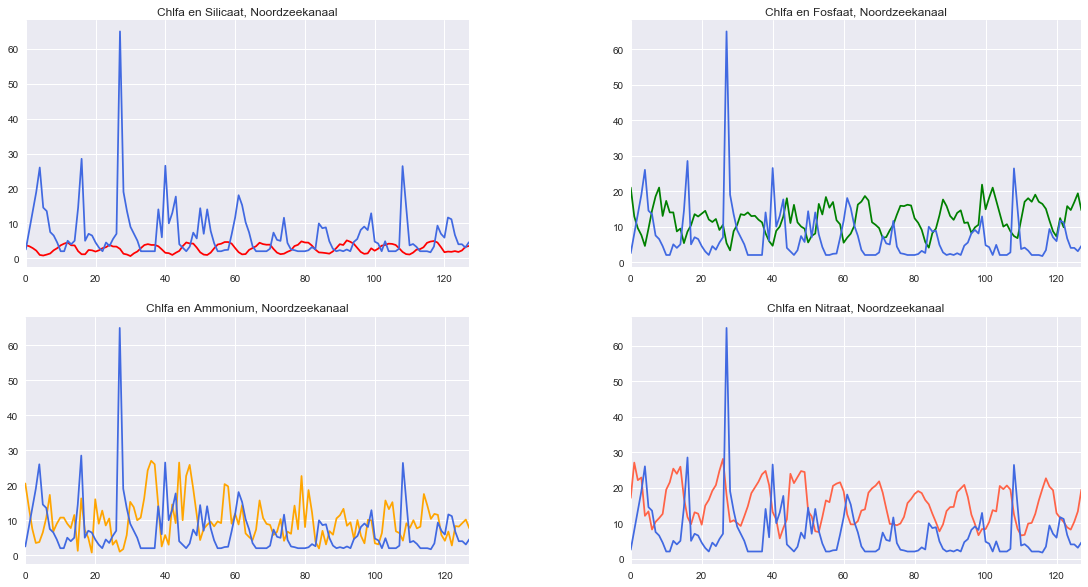

In [96]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10), subplot_kw={'aspect':'equal'})
sns.set(rc={"font.size":20,"axes.labelsize":20})

sns.tsplot([df_nrdzee.SiO2_HDH_Sinf], color='red', ax=ax1, legend=True, )
sns.tsplot([df_nrdzee.CHLFa_HDH_NVT], color='royalblue', ax=ax1, legend=True, )
ax1.set_title('Chlfa en Silicaat, Noordzeekanaal')

sns.tsplot([df_nrdzee.PO4_HDH_Pnf * 100] , color='green', ax=ax2)
sns.tsplot([df_nrdzee.CHLFa_HDH_NVT], color='royalblue', ax=ax2)
ax2.set_title('Chlfa en Fosfaat, Noordzeekanaal')

sns.tsplot([df_nrdzee.NH4_HDH_Nnf *50], color='orange', ax=ax3)
sns.tsplot([df_nrdzee.CHLFa_HDH_NVT], color='royalblue', ax=ax3)
ax3.set_title('Chlfa en Ammonium, Noordzeekanaal')

sns.tsplot([df_nrdzee.NO3_HDH_Nnf * 10], color='tomato', ax=ax4)
sns.tsplot([df_nrdzee.CHLFa_HDH_NVT], color='royalblue', ax=ax4)
ax4.set_title('Chlfa en Nitraat, Noordzeekanaal')

plt.show()

fig.savefig('ts_nrdzee_python.png')



#### Selecteer en visualiseer locaties in een bepaald stroomgebied: Maas

In [97]:
df_maas = df_RWS.query('GBD == "MAAS"')
df_maas.head(10)

DATUM       LOC   GBD    TG     X_WGS     Y_WGS      X_RD      Y_RD  \
3   2006-01-03  EIJSDPTN  MAAS  -4.0  5.699107  50.77950  177000.0  310000.0   
15  2006-01-17   BELFBVN  MAAS  41.0  6.113325  51.31860  205620.0  370180.0   
16  2006-01-17  EIJSDPTN  MAAS  48.0  5.699107  50.77950  177000.0  310000.0   
21  2006-01-17    STEVWT  MAAS  50.0  5.841665  51.13109  186812.0  349166.0   
33  2006-01-31  EIJSDPTN  MAAS  -6.0  5.699107  50.77950  177000.0  310000.0   
43  2006-02-14   BELFBVN  MAAS  51.0  6.113325  51.31860  205620.0  370180.0   
44  2006-02-14  EIJSDPTN  MAAS  52.0  5.699107  50.77950  177000.0  310000.0   
49  2006-02-14    STEVWT  MAAS  54.0  5.841665  51.13109  186812.0  349166.0   
63  2006-02-28  EIJSDPTN  MAAS   7.0  5.699107  50.77950  177000.0  310000.0   
74  2006-03-14   BELFBVN  MAAS   5.0  6.113325  51.31860  205620.0  370180.0   

    %DS_HDH_NVT  %GR_HDH_NVT  %O2_HDH_NVT  BaA_HDH_NVT  BaA_HDH_dg  \
3          40.0         71.0         99.2          NaN        1.00   
15          NaN         68.0         81.0         0.01         NaN   
16          NaN         85.0         85.0         0.01         NaN   
21          NaN         74.0         77.9          NaN         NaN   
33         36.0         54.0         88.0          NaN        0.88   
43          NaN         60.0         97.0         0.01         NaN   
44         38.0         51.0         80.0         0.01        0.88   
49          NaN         57.0         80.1          NaN         NaN   
63         46.0         80.0         96.4          NaN        0.86   
74          NaN         83.0         86.0         0.01         NaN   

    CHLFa_HDH_NVT  Cl_HDH_NVT  Cl_HDH_nf  KjN_HDH_N  KjN_HDH_Ndg  N_HDH_NVT  \
3             2.0         NaN       50.1       0.92      11000.0        NaN   
15            2.0         NaN       56.8       0.61          NaN        NaN   
16            2.0         NaN       49.6       0.59          NaN        NaN   
21            2.0         NaN       55.0       0.45          NaN        NaN   
33            2.0         NaN       39.8       0.67      15000.0        NaN   
43            4.0         NaN       61.3       0.76          NaN        NaN   
44            4.0         NaN       54.6       1.20      17000.0        NaN   
49            4.0         NaN       61.9       0.81          NaN        NaN   
63            2.0         NaN       27.4       0.67       8100.0        NaN   
74            8.0         NaN       29.7       1.90          NaN        NaN   

    N_HDH_nf  N_HDH_pg  NH4_HDH_Nnf  NO2_HDH_Nnf  NO3_HDH_Nnf  O2_HDH_NVT  \
3        NaN       NaN         0.30         0.06         4.22        12.3   
15       NaN       NaN         0.22         0.05         4.10        10.5   
16       NaN       NaN         0.37         0.05         4.30        10.7   
21       NaN       NaN         0.29         0.07         4.32         9.4   
33       NaN       NaN         0.31         0.05         4.03        11.5   
43       NaN       NaN         0.25         0.05         3.95         8.7   
44       NaN       NaN         0.78         0.06         3.90         9.9   
49       NaN       NaN         0.35         0.06         4.11         9.7   
63       NaN       NaN         0.18         0.03         4.32        11.3   
74       NaN       NaN         0.15         0.03         3.89        11.0   

    P_HDH_NVT  P_HDH_dg  P_HDH_nf  P_HDH_pg  PO4_HDH_Pnf  Ra226_HDH_NVT  \
3        0.22       4.8       NaN       NaN        0.150            NaN   
15       0.35       NaN       NaN       NaN        0.150            NaN   
16       0.26       NaN       NaN       NaN        0.240            2.0   
21       0.18       NaN       NaN       NaN        0.320            NaN   
33       0.21       5.2       NaN       NaN        0.220            NaN   
43       0.25       NaN       NaN       NaN        0.150            NaN   
44       0.27       5.2       NaN       NaN        0.160            NaN   
49       0.27       NaN       NaN      

In [98]:
df_maas['DATUM'] = df_maas['DATUM'].str.slice(0, 7)


C:\Users\Andries Jan\anacond\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [99]:
df_maas['LOC'].value_counts()

EIJSDPTN    284
BELFBVN     142
STEVWT      130
Name: LOC, dtype: int64

In [100]:
df_maas = df_maas.groupby(['DATUM']).mean()
df_maas.head()

TG     X_WGS      Y_WGS      X_RD      Y_RD  %DS_HDH_NVT  \
DATUM                                                                   
2006-01   25.80  5.810462  50.957638  184686.4  329869.2         38.0   
2006-02   41.00  5.838301  51.002172  186608.0  334836.5         42.0   
2006-03   28.75  5.838301  51.002172  186608.0  334836.5         44.5   
2006-04   77.75  5.838301  51.002172  186608.0  334836.5         43.0   
2006-05  154.00  5.838301  51.002172  186608.0  334836.5         47.0   

         %GR_HDH_NVT  %O2_HDH_NVT  BaA_HDH_NVT  BaA_HDH_dg  CHLFa_HDH_NVT  \
DATUM                                                                       
2006-01    70.400000       86.220        0.010        0.94           2.00   
2006-02    62.000000       88.375        0.010        0.87           3.50   
2006-03    82.500000       96.250        0.010        1.25           7.00   
2006-04    72.666667       92.950        0.010        1.03           5.75   
2006-05    71.500000       84.775        0.015        0.89          12.75   

         Cl_HDH_NVT  Cl_HDH_nf  KjN_HDH_N  KjN_HDH_Ndg  N_HDH_NVT  N_HDH_nf  \
DATUM                                                                         
2006-01         NaN     50.260     0.6480      13000.0        NaN       NaN   
2006-02         NaN     51.300     0.8600      12550.0        NaN       NaN   
2006-03         NaN     27.700     1.6000       6200.0        NaN       NaN   
2006-04         NaN     27.925     0.7200      12050.0        NaN       NaN   
2006-05         NaN     35.125     0.6075       9400.0        NaN       NaN   

         N_HDH_pg  NH4_HDH_Nnf  NO2_HDH_Nnf  NO3_HDH_Nnf  O2_HDH_NVT  \
DATUM                                                                  
2006-01       NaN       0.2980        0.056       4.1940       10.88   
2006-02       NaN       0.3900        0.050       4.0700        9.90   
2006-03       NaN       0.1600        0.030       3.8075       11.65   
2006-04       NaN       0.1625        0.045       3.6275       10.25   
2006-05       NaN       0.2700        0.065       3.0750        8.05   

         P_HDH_NVT  P_HDH_dg  P_HDH_nf  P_HDH_pg  PO4_HDH_Pnf  Ra226_HDH_NVT  \
DATUM                                                                          
2006-01     0.2440      5.00       NaN       NaN      0.21600            2.0   
2006-02     0.2575      3.85       NaN       NaN      0.13975            NaN   
2006-03     0.1075      1.60       NaN       NaN      0.05875            2.0   
2006-04     0.1225      2.55       NaN       NaN      0.08075            NaN   
2006-05     0.3725      3.20       NaN       NaN      0.22175            4.0   

         Ra226_HDH_dg  SALNTT_HDH_NVT  SiO2_HDH_Sinf  SiO2_HDH_Sipg  \
DATUM                                                                 
2006-01           NaN            0.30         3.5600            NaN   
2006-02           NaN            0.30         3.5275            NaN   
2006-03           NaN            0.15         2.8325            NaN   
2006-04           NaN            0.20         2.5725            NaN   
2006-05           NaN            0.25         1.0550            NaN   

         WINDSHD_HDH_NVT  ZICHT_HDH_NVT  ZS_HDH_NVT  pH_HDH_NVT  
DATUM                                                            
2006-01             2.00          10.80        4.40       7.840  
2006-02             1.50           9.00        6.75       7.950  
2006-03             1.50           3.00       39.00       8.175  
2006-04             1.25           9.25        7.00       8.025  
2006-05             1.50           9.25        9.75       7.850

In [101]:
df_maas = df_maas.interpolate()

In [102]:
df_maas.isnull().sum() / df_maas.shape[0] * 100

TG                   0.0
X_WGS                0.0
Y_WGS                0.0
X_RD                 0.0
Y_RD                 0.0
%DS_HDH_NVT          0.0
%GR_HDH_NVT          0.0
%O2_HDH_NVT          0.0
BaA_HDH_NVT          0.0
BaA_HDH_dg           0.0
CHLFa_HDH_NVT        0.0
Cl_HDH_NVT         100.0
Cl_HDH_nf            0.0
KjN_HDH_N            0.0
KjN_HDH_Ndg          0.0
N_HDH_NVT          100.0
N_HDH_nf           100.0
N_HDH_pg           100.0
NH4_HDH_Nnf          0.0
NO2_HDH_Nnf          0.0
NO3_HDH_Nnf          0.0
O2_HDH_NVT           0.0
P_HDH_NVT            0.0
P_HDH_dg             0.0
P_HDH_nf           100.0
P_HDH_pg           100.0
PO4_HDH_Pnf          0.0
Ra226_HDH_NVT        0.0
Ra226_HDH_dg       100.0
SALNTT_HDH_NVT       0.0
SiO2_HDH_Sinf        0.0
SiO2_HDH_Sipg      100.0
WINDSHD_HDH_NVT      0.0
ZICHT_HDH_NVT        0.0
ZS_HDH_NVT           0.0
pH_HDH_NVT           0.0
dtype: float64

In [103]:
df_maas.dropna(axis=1, inplace=True)
df_maas.shape

(132, 28)

In [104]:
df_maas.index = pd.to_datetime(df_maas.index)

In [110]:
df_maas.to_csv('df_maas.csv')

C:\Users\Andries Jan\anacond\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


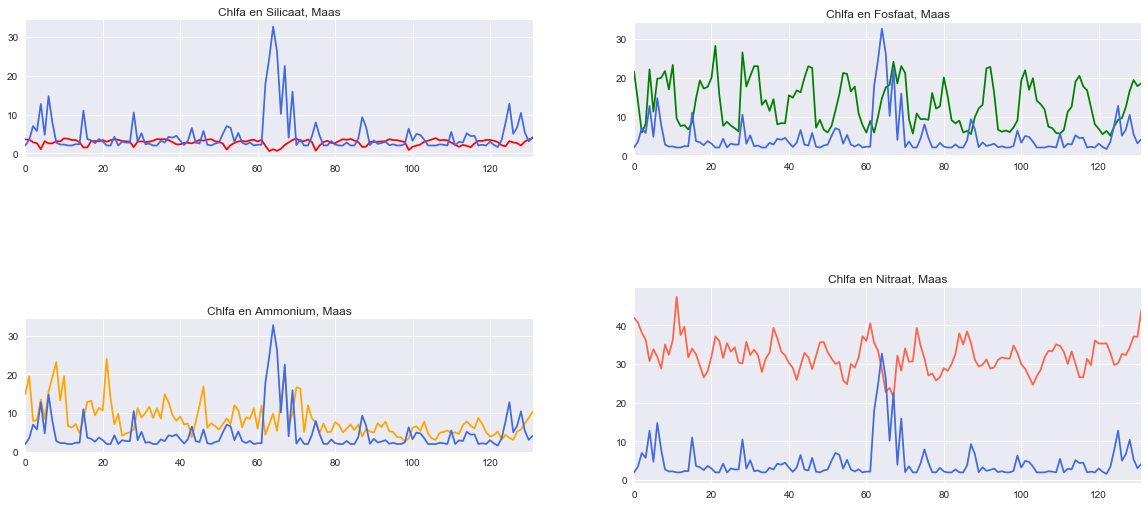

In [105]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10), subplot_kw={'aspect':'equal'})
sns.set(rc={"font.size":20,"axes.labelsize":20})

sns.tsplot([df_maas.SiO2_HDH_Sinf], color='red', ax=ax1)
sns.tsplot([df_maas.CHLFa_HDH_NVT], color='royalblue', ax=ax1)
ax1.set_title('Chlfa en Silicaat, Maas')

sns.tsplot([df_maas.PO4_HDH_Pnf * 100] , color='green', ax=ax2)
sns.tsplot([df_maas.CHLFa_HDH_NVT], color='royalblue', ax=ax2)
ax2.set_title('Chlfa en Fosfaat, Maas')

sns.tsplot([df_maas.NH4_HDH_Nnf *50], color='orange', ax=ax3)
sns.tsplot([df_maas.CHLFa_HDH_NVT], color='royalblue', ax=ax3)
ax3.set_title('Chlfa en Ammonium, Maas')

sns.tsplot([df_maas.NO3_HDH_Nnf * 10], color='tomato', ax=ax4)
sns.tsplot([df_maas.CHLFa_HDH_NVT], color='royalblue', ax=ax4)
ax4.set_title('Chlfa en Nitraat, Maas')

plt.show()

fig.savefig('ts_maas_python.png')

#### Selecteer en visualiseer locaties in een bepaald stroomgebied: Maas

In [106]:
# Percentage missende waarden per kolom, voor een aantal kolommen flink naar beneden
df_rws.isnull().sum() / df_rws.shape[0] * 100

DATUM               0.000000
LOC                 0.000000
GBD                 0.000000
TG                  0.000000
X_WGS               0.000000
Y_WGS               0.000000
X_RD                0.000000
Y_RD                0.000000
%DS_HDH_NVT        82.065934
%GR_HDH_NVT        61.483516
%O2_HDH_NVT         4.505495
BaA_HDH_NVT        48.329670
BaA_HDH_dg         81.604396
CHLFa_HDH_NVT       0.000000
Cl_HDH_nf          29.879121
KjN_HDH_N          45.428571
N_HDH_NVT          53.384615
N_HDH_nf           55.362637
N_HDH_pg           52.791209
NH4_HDH_Nnf         2.428571
NO2_HDH_Nnf         0.483516
NO3_HDH_Nnf         0.428571
O2_HDH_NVT          1.362637
P_HDH_NVT           1.549451
P_HDH_nf           54.208791
P_HDH_pg           53.450549
PO4_HDH_Pnf         0.670330
Ra226_HDH_NVT      93.043956
Ra226_HDH_dg       99.912088
SALNTT_HDH_NVT     14.989011
SiO2_HDH_Sinf       0.428571
SiO2_HDH_Sipg      98.340659
WINDSHD_HDH_NVT     0.000000
ZICHT_HDH_NVT      23.989011
ZS_HDH_NVT    

In [107]:
# Locaties met meeste metingen sorteren, om geschikte locaties voor analyse te kiezen
df_rws['LOC'].value_counts()

EIJSDPTN        284
LOBPTN          283
SCHAARVODDL     277
MAASSS          260
NOORDWK10       170
VLISSGBISSVH    167
LODSGT          166
HUIBGOT         164
GROOTGND        164
BOOMKDP         163
DANTZGT         163
MARSDND         162
NOORDWK70       158
TERSLG10        154
TERSLG50        150
NOORDWK20       147
NOORDWK2        144
STEENBGN        143
BRIENOD         142
BELFBVN         142
GENMDN          142
PUTTHK          142
SASVGT          142
BOVSS           141
KAMPN           141
               ... 
WOLDWMDN         61
TERSLG235        60
ROTTMPT70        60
TERSLG175        59
HERKGN           57
SCHARDKDPPT      52
KEIZVR           45
HAMMOT           39
ZUIDOLWOT        36
EEMMDK23         27
WESTHVN2         23
AMRKHVN2         23
ZWAAN            23
ZOUTKPLZGT       21
REVE             20
VURN             13
ZIJKNLD1         12
ZIJKNLE2         12
NIEUWGN          10
WIELGN            8
NULDHK            7
ROTTMPT50         6
NIEUWSS           5
LAUWOHVMD         2


In [108]:
# Correlatiematrix
df_rws.corr()

TG     X_WGS     Y_WGS      X_RD      Y_RD  \
TG               1.000000 -0.035716  0.015268 -0.035887  0.015409   
X_WGS           -0.035716  1.000000  0.262179  0.999724  0.259692   
Y_WGS            0.015268  0.262179  1.000000  0.272365  0.999985   
X_RD            -0.035887  0.999724  0.272365  1.000000  0.269853   
Y_RD             0.015409  0.259692  0.999985  0.269853  1.000000   
%DS_HDH_NVT     -0.147733  0.112345 -0.524608  0.110106 -0.524151   
%GR_HDH_NVT     -0.172736 -0.129825 -0.255355 -0.129768 -0.254898   
%O2_HDH_NVT      0.021127 -0.151761  0.260113 -0.149507  0.260793   
BaA_HDH_NVT     -0.084015  0.022844 -0.129836  0.022617 -0.130332   
BaA_HDH_dg      -0.122130  0.054103 -0.230710  0.057213 -0.231557   
CHLFa_HDH_NVT    0.109603  0.111114  0.030509  0.109823  0.029533   
Cl_HDH_nf       -0.011328 -0.347990  0.259811 -0.352079  0.263295   
KjN_HDH_N       -0.192111  0.160258  0.186936  0.158445  0.187198   
N_HDH_NVT       -0.283123  0.406066 -0.111845  0.397095 -0.111265   
N_HDH_nf        -0.313637  0.337208 -0.158194  0.328175 -0.157551   
N_HDH_pg        -0.087274  0.457833  0.084335  0.452996  0.084488   
NH4_HDH_Nnf     -0.231043  0.054275 -0.210800  0.051416 -0.211207   
NO2_HDH_Nnf     -0.087875  0.037346 -0.272801  0.034760 -0.273088   
NO3_HDH_Nnf     -0.286091  0.260625 -0.457868  0.258687 -0.459028   
O2_HDH_NVT      -0.541477  0.097630  0.045486  0.099362  0.044772   
P_HDH_NVT       -0.021945  0.107543 -0.299394  0.102074 -0.299494   
P_HDH_nf         0.008224  0.078476 -0.149519  0.072510 -0.149023   
P_HDH_pg        -0.107037  0.451669  0.075673  0.446867  0.076197   
PO4_HDH_Pnf      0.005537 -0.009880 -0.369956 -0.013819 -0.370063   
Ra226_HDH_NVT    0.078950 -0.107454  0.009393 -0.109241  0.009792   
Ra226_HDH_dg     0.070613 -0.174613 -0.164071 -0.171505 -0.164695   
SALNTT_HDH_NVT   0.062084 -0.383278  0.381382 -0.383116  0.384140   
SiO2_HDH_Sinf   -0.336457  0.330168 -0.330740  0.328216 -0.332143   
SiO2_HDH_Sipg   -0.260903  0.482373 -0.530765  0.480450 -0.531844   
WINDSHD_HDH_NVT -0.021263 -0.120848  0.408205 -0.117885  0.408778   
ZICHT_HDH_NVT    0.127644 -0.226343 -0.154592 -0.224751 -0.154359   
ZS_HDH_NVT      -0.114641  0.194231  0.087578  0.187589  0.088421   
pH_HDH_NVT       0.003153  0.004670  0.011129  0.004716  0.011070   

                 %DS_HDH_NVT  %GR_HDH_NVT  %O2_HDH_NVT  BaA_HDH_NVT  \
TG                 -0.147733    -0.172736     0.021127    -0.084015   
X_WGS               0.112345    -0.129825    -0.151761     0.022844   
Y_WGS              -0.524608    -0.255355     0.260113    -0.129836   
X_RD                0.110106    -0.129768    -0.149507     0.022617   
Y_RD               -0.524151    -0.254898     0.260793    -0.130332   
%DS_HDH_NVT         1.000000     0.621764    -0.087127     0.237355   
%GR_HDH_NVT         0.621764     1.000000    -0.077482    -0.007219   
%O2_HDH_NVT        -0.087127    -0.077482     1.000000    -0.069478   
BaA_HDH_NVT         0.237355    -0.007219    -0.069478     1.000000   
BaA_HDH_dg          0.062626     0.096333    -0.209321     0.052304   
CHLFa_HDH_NVT      -0.285496    -0.252322     0.171036     0.030184   
Cl_HDH_nf           0.009422     0.105098     0.306610    -0.103398   
KjN_HDH_N          -0.194157    -0.155708    -0.219728     0.078190   
N_HDH_NVT           0.511347          NaN    -0.219745     0.035514   
N_HDH_nf            0.523946          NaN    -0.226702     0.016084   
N_HDH_pg            0.090826          NaN    -0.103730     0.078447   
NH4_HDH_Nnf        -0.007059     0.039665    -0.424846     0.127799   
NO2_HDH_Nnf        -0.051332    -0.046778    -0.412680     0.099385   
NO3_HDH_Nnf         0.501328     0.294959    -0.434889     0.153438   
O2_HDH_NVT         -0.030470    -0.002405     0.537585     0.036884   
P_HDH_NVT           0.178635     0.059514    -0.442847     0.179513   
P_HDH_nf            0.618343          NaN    -0.162335     0.023840   
P_HDH_pg            0.693940          NaN  

## Detecteren outliers

In [109]:
# Schalen waarden dataframe om outliers te kunnen vergelijken
df_rws1 = df_rws.drop(columns=['DATUM','LOC'])
df_rws_scaled=(np.absolute(df_rws1-df_rws1.mean()))/(df_rws1.max()-df_rws1.min())
df_rws_scaled

ValueError: can only convert an array of size 1 to a Python scalar

In [ ]:
# Seaborn swarmplot
df_rws_scaled = pd.melt(df_rws_scaled)

df_rws_scaled.dropna(inplace=True)
df_rws_scaled['variable'] = df_rws_scaled.astype(str)
df_rws_scaled['value'] = pd.to_numeric(df_rws_scaled['value'])

df_rws_scaled

fig, ax = plt.subplots(figsize=(20,15))


p = sns.boxplot(ax=ax, x= 'value', y= 'variable', data = df_rws_scaled, whis=4)
#p1 = sns.violinplot(ax=ax, x='value', y='variable', data = df_rws_scaled, color='grey', alpha=.8)
plt.xlabel('Geschaalde waarden (0-1)')
plt.ylabel('Variabelen')
plt.show()


In [ ]:
# Functie voor vinden outliers obv IQR
def find_outliers(column, whisker):
    column = column.dropna()
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    floor = q1 - whisker * iqr
    ceiling = q3 + whisker * iqr
    outlier_ind = list(column.index[(column < floor) | (column > ceiling)])
    outlier_val = list(column[outlier_ind])
    
    dic = dict(zip(outlier_ind, outlier_val))
    locs = list(df_rws['LOC'][df_rws.index[[outlier_ind]]])
    
    return (locs, outlier_val)

In [ ]:
def find_outliers1(column, whisker):
    column = column.dropna()
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    floor = q1 - whisker * iqr
    ceiling = q3 + whisker * iqr
    outlier_ind = list(column.index[(column < floor) | (column > ceiling)])
    outlier_val = list(column[outlier_ind])
    
    dic = dict(zip(outlier_ind, outlier_val))
    
    
    return dic

In [ ]:
# Functie voor vinden outliers obv kernel density estimation
from sklearn.preprocessing import scale
from statsmodels.nonparametric.kde import KDEUnivariate

def find_outliers_kde(column, fraction):
    column = column.dropna()
    column_scaled = scale(list(column))
    kde = KDEUnivariate(column_scaled)
    kde.fit(bw="scott", fft=True)
    pred = kde.evaluate(column_scaled)
    
    n = sum(pred < fraction)
    outlier_ind = np.asarray(pred).argsort()[:n]
    outlier_val = np.asarray(column)[outlier_ind]
    
    return outlier_ind, outlier_val


In [ ]:
# Functie voor verwijderen outliers obv IQR
def remove_outliers(column, whisker):
    
    dic = find_outliers1(column, whisker)
    index_list = list(dic.keys())
    df_rws1 = df_rws.drop(df_rws.index[[index_list]])
    
    return df_rws1
    
        

In [ ]:
df_rws1 = remove_outliers(df_rws['CHLFa_HDH_NVT'], 10)
df_rws1.info()

In [ ]:
# Functie voor selecteren locaties

def select_loc(loc):
    return df_rws[df_rws['LOC'] == loc] 
    

In [ ]:
# Outliers Chlfa
print(np.sort(find_outliers(df_rws['CHLFa_HDH_NVT'], 10)))


In [ ]:
df_rws['LOC'][df_rws.index[[89, 591, 1894, 2888, 2924, 3296, 3835, 4892, 5864, 8784]]]

In [ ]:
# Outliers andere kolom
print(find_outliers(df_rws['P_HDH_pg'], 10))


In [ ]:
# Outliers Chlfa kde
ind, val = find_outliers_kde(df_rws['CHLFa_HDH_NVT'], .001)
print(np.sort(val))

## Verschillende plotten

In [ ]:
# Plot chla tov stikstof en fosfor
fig, ax = plt.subplots(figsize=(20,50), subplot_kw={'aspect':'equal'})
#sns.set(rc={"font.size":20,"axes.labelsize":20})
#ax = sns.regplot(x='P_HDH_nf'*100, y='CHLFa_HDH_NVT', data=df_cyan_wide1)

#vermenigvuldig P en N met 100; to do: outliers
plt.scatter((df_PAR_wide['P_HDH_NVT']*100) + (df_PAR_wide['KjN_HDH_N']*100), (df_PAR_wide['CHLFa_HDH_NVT']))
plt.show()

In [ ]:
# Fosfor door de tijd heen
df_PAR_wide['P_HDH_NVT'].plot()
plt.show()

In [ ]:
gdf_nl = gpd.read_file('C:/Users/ajeez/projectopdracht-module2-rws/data/2018-Imergis_gemeentegrenzen_met_water.shp')
gdf_nl.crs


In [ ]:
gdf_water = gpd.read_file('C:/Users/ajeez/projectopdracht-module2-rws/data/NL-water-simpel.shp')
gdf_water.crs

# Plotten locaties met chlfa metingen, duurt gruwelijk lang door lambda functie voor annotatie
fig, ax = plt.subplots(figsize=(24,24), subplot_kw={'aspect':'equal'})

# Maak geodataframe 
geometry = [Point(xy) for xy in zip(df_cyan_wide['X_RD'], df_cyan_wide['Y_RD'])]
#df = df.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf_P_wide = gpd.GeoDataFrame(df_cyan_wide, crs=crs, geometry=geometry)

# Plotten: 1) Nederland 2) Wateren 3) Locaties
gdf_nl.plot(ax=ax, edgecolor='darkgrey', color='#f06e42')
#gdf_water.plot(ax=ax, color='#4d4dff')
#gdf_P_wide[gdf_P_wide['CHLFa_HDH_NVT'].notna()].plot(column='CHLFa_HDH_NVT', cmap='jet', 
                                                                    #scheme='quantiles', ax=ax, marker="8", markersize=150, 
                                                                    #legend=True)
# Plotten namen locaties
#gdf_P_wide.apply(lambda x: ax.annotate(s=x.LOC, xy=x.geometry.centroid.coords[0], ha='left', va='top', size=8),axis=1)


#plt.ylim([300000, 635000])
#plt.title("Cholorofyl a waarden per locatie 2006-2016(ug/l)", fontsize=20)

#leg = p.get_legend()
#leg.set_title("Cholorofyl a waarden (ug/l)")
#eg.set_bbox_to_anchor((0., 0., 0.3, 0.6))
#plt.show()
#fig.savefig('ChlNL.png')

mplleaflet.display(fig=ax.figure)








In [ ]:
# Oefenplot
fig, ax = plt.subplots(figsize=(16,16), subplot_kw={'aspect':'equal'})

geometry = [Point(xy) for xy in zip(df_cyan['X_RD'], df_cyan['Y_RD'])]
#df = df.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf_cyan = gpd.GeoDataFrame(df_cyan, crs=crs, geometry=geometry)

gdf_nl.plot(ax=ax)
p = gdf_cyan[gdf_cyan['DATUM'].str.contains('2016-07', case = False)].plot(ax=ax, cmap='jet', marker="8", markersize=150, 
                                                                       column='WAARDE', scheme='quantiles', legend=True)
leg = p.get_legend()
leg.set_title("Waarde")
leg.set_bbox_to_anchor((0., 0., 0.35, 0.7))
plt.ylim([300000, 635000])

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16,16), subplot_kw={'aspect':'equal'})

geometry = [Point(xy) for xy in zip(df_rws['X_RD'], df_rws['Y_RD'])]
#df = df.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:28992'}
gdf_rws = gpd.GeoDataFrame(df_rws, crs=crs, geometry=geometry)

gdf_nl.plot(ax=ax)
p = gdf_rws.plot(ax=ax,  marker="8", markersize=150)
                                                                       
for line in range(0,gdf_rws.shape[0]):
     p.text(gdf_rws.X_RD[line]+0.2, gdf_rws.Y_RD[line], "hoi", horizontalalignment='left', 
             size='medium', color='black', weight='semibold')

#leg = p.get_legend()
#leg.set_title("Land cover")
#leg.set_bbox_to_anchor((0., 0., 0.35, 0.7))
#plt.ylim([300000, 635000])

mplleaflet.show(fig=p.figure, crs={'init': 'epsg:28992'})

In [ ]:
print(list(df_chlfa_group['LOC']))